# How deep are financial models?
<div style="text-align: right">(C) Nikolai Nowaczyk, Jörg Kienitz, Sarp Kaya Acar, Qian Liang 2019</div>

In this notebook, we apply deep learning techniques to financial derivative pricing models, namely the Black-Scholes model and the Heston model. But just how deep does a neural network have to be to adaequately capture the pricing function? We employ a [systematic technique to determine a good network topology](https://github.com/niknow/machine-learning-examples/blob/master/network_topology_selection/network_topology_selection.ipynb) and inspect the results. We find that both, the Black-Scholes and the Heston pricing function can be learned quite easily by a standard multilayer perceptron (MLP).

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras
import os
from ipywidgets import interact
import ipywidgets as wg
import json
import pickle
import unittest

from keras_grid import MLPGrid, LSTMGrid
from pricinglib import BlackScholesCallPrice, HestonCallPrice

%matplotlib notebook

In [3]:
data_folder = os.path.join(os.getcwd(), 'data')
picture_folder = 'pics'

export_figures = True
def export_figure(fig, filename, extension='.pdf', **kwargs):
    if export_figures:
        fig.savefig(os.path.join(os.path.join(os.getcwd(), picture_folder), filename + extension), **kwargs)

# Models

## Black-Scholes Model

Let $(\Omega, \mathcal{F}, \mathbb{Q})$ be a probability space (where we think of $\mathbb{Q}$ as the risk-neutral measure). Then the Black-Scholes model assumes the following stochastic dynamics for the stock:
\begin{align}
dS_t = r S_t dt + \sigma S_t dW_t, \qquad S_0 = s_0
\end{align}
where
* $s_0$ is the initial value for the stock
* $r \in \mathbb{R}$ is a fixed *risk-free rate*, 
* $\sigma > 0$ is the *volatility*, 
and the process $W_t$ is a Brownian motion. 

In the Black-Scholes model, a European call option $C = C(T,K)$ with maturity $T>0$ and strike $K>0$ has market value 
\begin{align}
    C_t = \mathbb{E}_t[(S_T - K)^+] = S_t \Phi(d_1) - K \exp(-r (T-t)) \Phi(d_2),
\end{align}
where $\Phi$ denotes the cdf of the standard normal distribution and 
$$ d_1 := \frac{1}{\sqrt{T-t}} \Big( \log\Big( \frac{S_t}{K} \Big) + (r + \frac{\sigma^2}{2}) (t-T) \Big), \quad
d_2 := d_1 - \sigma \sqrt{T-t}$$

## Heston Model
The Heston model assumes the following stochastic dynamics:
\begin{align}
    dS_t &= rS_t dt + \sqrt{V_t}dW_t, \quad S_0 = s_0 \\
    dV_t &= \kappa(\theta - V_t) S_t dt + \xi \sqrt{V_t} dZ_t, && V_0 = v_0,
\end{align}
where
* $s_0$ is the initial value for the stock,
* $v_0$ is the initial value for the volatility,
* $r$ is the risk-free rate,
* $\kappa$ is the mean reversion rate of the volatility,
* $\xi$ is the volatility of the volatility
* $\rho$ is the assumed correlation between the Brownian motions $W_t$ and $Z_t$.

One typically assumes that the parameters are chosen such that the Feller condition holds: $2 \kappa \theta > \xi^2$.

The option price in a Heston model can be computed (for $t=0$) via 
\begin{align}
    C_0(T,K) = S_0 + \Pi_1 - e^{-rT} K \Pi_2,
\end{align}
where $\Pi_1$ and $\Pi_2$ are given as integrals over the characteristic function $\Psi = \Psi_{\ln(S_T)}$ of $\ln(S_T)$:
\begin{align}
    \Pi_1 &= \frac{1}{2} + \frac{1}{\pi}\int_0^{\infty}{\operatorname{Re}\Big( \frac{e^{-iw \ln(K)} \Psi(w-i)}{i w \Psi(-i)} \Big) dw} \\
    \Pi_2 &= \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty}{\operatorname{Re}\Big( \frac{e^{-iw \ln(K)} \Psi(w)}{i w } \Big) dw}
\end{align}

# Generating the data set

When generating a training set for any neural network that learns a derivative pricing function of any financial model, one always has two choices:

* **Option A:** First generate realizations of the underlying and then price the derivative.
* **Option B:** Generate derivative prices directly using synthetic values of the underlying.

Option A has the advantage that the distribution of the derivative prices is more concentrated around realistic values. This means that the network will have more data to learn the derivative prices for typical values of the underlying, but less data for corner cases. Option B has the advantage that one can simply chose the ranges irrespective on how they might be distributed according to the underyling stochastic dynamics. 

For the Black-Scholes model, if we only consider $t=0$ pricing, it does not matter, which option we chose as the option prices only depend linearly on $S_0$. Thus, in the following, we consider $t=0$ pricing.

In [4]:
# parameter configuration
S0=100
T_max=1
maturity_grid = np.linspace(1/300, T_max, 300)
strike_grid = np.linspace(S0*0.8, S0*1.2, 400)
maturity_grid_, strike_grid_ = np.meshgrid(maturity_grid, strike_grid)
maturity_grid_ = maturity_grid_.ravel()
strike_grid_ = strike_grid_.ravel()

# heston model
v0 = 0.02
vLong = 0.04
kappa = 0.3
volvol = 0.4
rho = -0.6
q=0

# black scholes model
S = 100  # spot price
r = 0.03  # risk-free rate
sigma = np.sqrt(v0) # volatility

In [ ]:
# generation of the data set
df = pd.DataFrame({'K': strike_grid_,
                   'T': maturity_grid_,
                   'C_BlackScholes': BlackScholesCallPrice(S0, r, sigma, maturity_grid_, strike_grid_, t=0)})
df['C_Heston'] = df.apply(lambda row: HestonCallPrice(S0, row['T'], row['K'], r, q, v0, vLong, kappa, sigma, rho), axis=1)

In [91]:
df.to_pickle(os.path.join(data_folder, 'df_prices.pkl')) # save dataset to file

In [5]:
df = pd.read_pickle(os.path.join(data_folder, 'df_prices.pkl')) # load dataset from file

## Visualizing the data set

<IPython.core.display.Javascript object>


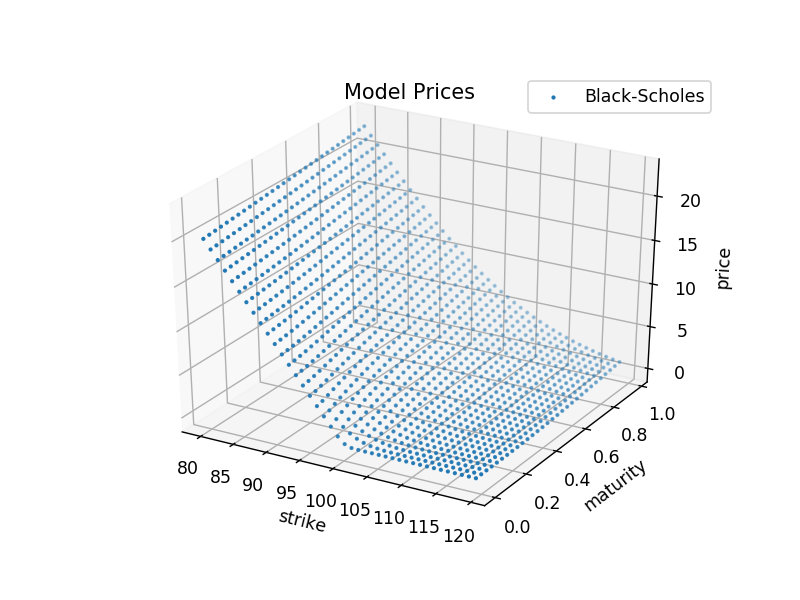

interactive(children=(SelectMultiple(description='Models', index=(0,), options=('BlackScholes', 'Heston'), val…

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# thinning out the df to avoid performance issues in the plot
df_3dplot = df[(df['T'].isin(maturity_grid[::10])) & (df['K'].isin(strike_grid[::10]))]


@interact(models=wg.SelectMultiple(
    options=['BlackScholes', 'Heston'],
    value=['BlackScholes'],
    description='Models',
))
def plot_dataset(models):
    ax.clear()
    if 'BlackScholes' in models:
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], df_3dplot['C_BlackScholes'], s=2, label='Black-Scholes')
    if 'Heston' in models:
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], df_3dplot['C_Heston'], s=2, label='Heston')
    ax.legend()
    ax.set_xlabel('strike')
    ax.set_ylabel('maturity')
    ax.set_zlabel('price')
    ax.set_title('Model Prices')
    export_figure(fig, 'model_prices_' + '_'.join(models))

We conclude that while the equations of the stochastic dynamics differ between the Black-Scholes and the Heston model, the resulting training sets are quite similar when viewed as data sets.

# Network Topology Selection

We define a 2D grid of Multilayer Perceptrons (MLPs) as candidate networks to learn the Black-Scholes and Heston pricing formula. The first dimension is the number of neurons in each layer, whereas the second dimension is the number of layers. When increasing the number of layers, we chose to decrease the number of neurons such that the resulting number of weights stays roughly constant. The rationale behind this is that we want to find a good network topology given a number of degrees of freedom. More details on this reasoning can be found [here](https://github.com/niknow/machine-learning-examples/blob/master/network_topology_selection/network_topology_selection.ipynb).
We also set up a comparable grid of LSTM networks and compare which of the two topologies is more suitable to learn the pricing function.

## Setting up the candidate models

In [7]:
pricing_models = ['BlackScholes', 'Heston']
pricing_model = pricing_models[1]  # change to 1 for Heston

In [8]:
# setup MLPs
n_o = 1
n_i = 2
range_units = np.array([2**i for i in range(6, 12)])
range_layers = np.array(list(range(2,6)))

mlpg = MLPGrid(num_inputs=n_i,
               num_outputs=n_o,
               range_units=range_units,
               range_layers=range_layers,
               constant_num_weights=True)
mlpg.initialize()

# setup LSTMs such that number of weights is comparable
range_units = np.array([LSTMGrid.num_units(n_i-1, n_o, n_L=range_layers[0], 
                                           n_w=MLPGrid.num_weights(n_i, n_o, n_L=range_layers[0], 
                                                                   n_u=mlpg.range_units[unit_idx]))
                       for unit_idx in range(len(mlpg.range_units))])

lstmg = LSTMGrid(num_inputs=n_i-1, 
                num_outputs=n_o, 
                range_units=range_units,
                range_layers=range_layers,
                num_time_steps=maturity_grid.shape[0],
                constant_num_weights=True)
lstmg.initialize()

<IPython.core.display.Javascript object>


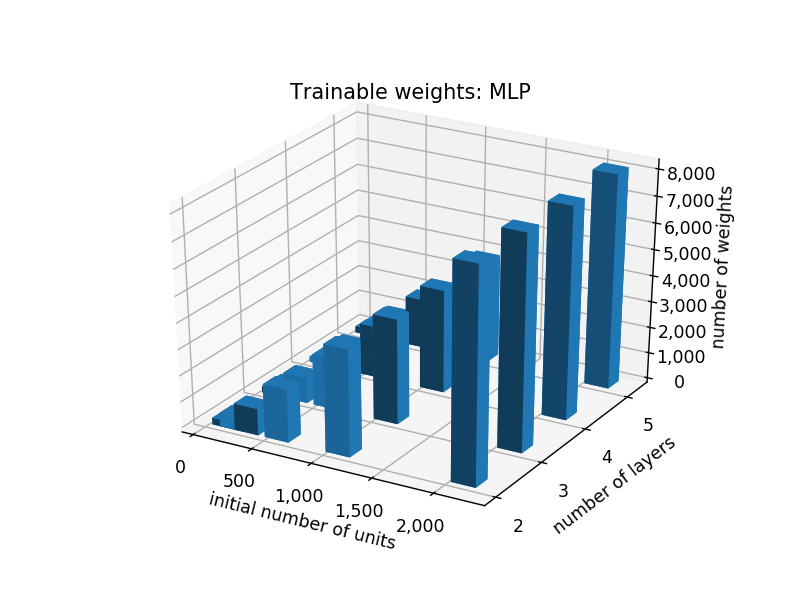

interactive(children=(RadioButtons(description='Network Type:', options=('MLP', 'LSTM'), value='MLP'), Output(…

In [9]:
# plot number of weights
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

@interact(network_type=wg.RadioButtons(options=['MLP', 'LSTM'],
                                       value='MLP',
                                       description='Network Type:'))
def plot_num_weights(network_type):
    if network_type=='MLP':
        mgrid=mlpg
        xx, yy = np.meshgrid(mlpg.range_units, mlpg.range_layers)
        width = 200
    else:
        mgrid=lstmg
        xx, yy = np.meshgrid(lstmg.range_units, lstmg.range_layers)
        width = 3
    x, y = xx.ravel(), yy.ravel()
    z = np.array([[mgrid.models[u][l].count_params() for u in range(len(range_units))] for l in range(len(range_layers))]).ravel()
    bottom = np.zeros_like(z)    
    depth = 0.25
    ax.clear()
    ax.bar3d(x, y, bottom, width, depth, z, shade=True)
    ax.set_title('Trainable weights: %s' % network_type)
    ax.set_xlabel('initial number of units')
    ax.set_ylabel('number of layers')
    ax.set_zlabel('number of weights')
    ax.set_yticks(range_layers)
    ax.zaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x))))
    export_figure(fig, 'trainable_weights_' + network_type)

When comparing the number of units between MLP and LSTM, we find that the number of units in the LSTM that generates the same number of weights than the MLP is quite low. That is because a layer in an LSTM has much more complexity than in an MLP, recall the introduction to LSTMs [here](https://nbviewer.jupyter.org/github/niknow/machine-learning-examples/blob/master/lstm_intro/lstm_intro.ipynb). This means that we would expect the LSTM to perform better in situations where this additional complexity is needed to solve the problem the network is trying to learn and to perform worse in cases where it is not needed, because then the MLP has much more units available per layer.

## Training the networks

In [113]:
compile_params = {
    'loss': 'mean_squared_error',
    'metrics': ['mean_squared_error', 'mean_absolute_error'],
    'optimizer': 'Adam',
}
mlpg.compile(**compile_params)
lstmg.compile(**compile_params)

In [114]:
fit_params={
    'validation_split': 0.2,
    'epochs': 50,
    'shuffle': True}

In [115]:
%time
mlpg.fit(x=df[['K', 'T']], y=df['C_'+pricing_model],**fit_params)
print("Training complete.")

Wall time: 0 ns
------------------------------
Fitting with units_index=0 and layers_index=0
------------------------------
Train on 96000 samples, validate on 24000 samples
Epoch 1/50
96000/96000 [==============================] - 98s 1ms/step - loss: 35.4879 - mean_squared_error: 35.4879 - mean_absolute_error: 5.1129 - val_loss: 28.1765 - val_mean_squared_error: 28.1765 - val_mean_absolute_error: 5.2476
Epoch 2/50
96000/96000 [==============================] - 50s 521us/step - loss: 16.2894 - mean_squared_error: 16.2894 - mean_absolute_error: 3.4162 - val_loss: 3.2022 - val_mean_squared_error: 3.2022 - val_mean_absolute_error: 1.5658
Epoch 3/50
96000/96000 [==============================] - 50s 524us/step - loss: 3.1912 - mean_squared_error: 3.1912 - mean_absolute_error: 1.3901 - val_loss: 7.0986 - val_mean_squared_error: 7.0986 - val_mean_absolute_error: 2.5414
Epoch 4/50
96000/96000 [==============================] - 50s 519us/step - loss: 0.7295 - mean_squared_error: 0.7295 - mean

96000/96000 [==============================] - 50s 524us/step - loss: 0.0382 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1374 - val_loss: 0.1191 - val_mean_squared_error: 0.1191 - val_mean_absolute_error: 0.2380
Epoch 20/50
96000/96000 [==============================] - 50s 522us/step - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1210 - val_loss: 0.0461 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1888
Epoch 21/50
96000/96000 [==============================] - 50s 525us/step - loss: 0.0241 - mean_squared_error: 0.0241 - mean_absolute_error: 0.1073 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1241
Epoch 22/50
96000/96000 [==============================] - 50s 522us/step - loss: 0.0212 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1021 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1557
Epoch 23/50
96000/96000 [==============================] - 51s 530us/step - 

96000/96000 [==============================] - 83s 863us/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0769 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1115
Epoch 39/50
96000/96000 [==============================] - 82s 856us/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0747 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0792
Epoch 40/50
96000/96000 [==============================] - 82s 859us/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0775 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0747
Epoch 41/50
96000/96000 [==============================] - 81s 849us/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0727 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0751
Epoch 42/50
96000/96000 [==============================] - 82s 853us/step - 

96000/96000 [==============================] - 60s 628us/step - loss: 0.3809 - mean_squared_error: 0.3809 - mean_absolute_error: 0.4523 - val_loss: 6.5507 - val_mean_squared_error: 6.5507 - val_mean_absolute_error: 2.3581
Epoch 7/50
96000/96000 [==============================] - 61s 638us/step - loss: 0.3181 - mean_squared_error: 0.3181 - mean_absolute_error: 0.4031 - val_loss: 5.4625 - val_mean_squared_error: 5.4625 - val_mean_absolute_error: 2.0784
Epoch 8/50
96000/96000 [==============================] - 75s 781us/step - loss: 0.2854 - mean_squared_error: 0.2854 - mean_absolute_error: 0.3796 - val_loss: 4.4741 - val_mean_squared_error: 4.4741 - val_mean_absolute_error: 1.8526
Epoch 9/50
96000/96000 [==============================] - 71s 741us/step - loss: 0.2615 - mean_squared_error: 0.2615 - mean_absolute_error: 0.3617 - val_loss: 5.1107 - val_mean_squared_error: 5.1107 - val_mean_absolute_error: 1.9969
Epoch 10/50
96000/96000 [==============================] - 74s 767us/step - los

96000/96000 [==============================] - 64s 664us/step - loss: 0.0181 - mean_squared_error: 0.0181 - mean_absolute_error: 0.0981 - val_loss: 0.2105 - val_mean_squared_error: 0.2105 - val_mean_absolute_error: 0.3889
Epoch 26/50
96000/96000 [==============================] - 64s 671us/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0886 - val_loss: 0.2022 - val_mean_squared_error: 0.2022 - val_mean_absolute_error: 0.3849
Epoch 27/50
96000/96000 [==============================] - 64s 664us/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0910 - val_loss: 0.2069 - val_mean_squared_error: 0.2069 - val_mean_absolute_error: 0.3701
Epoch 28/50
96000/96000 [==============================] - 64s 668us/step - loss: 0.0164 - mean_squared_error: 0.0164 - mean_absolute_error: 0.0910 - val_loss: 0.2689 - val_mean_squared_error: 0.2689 - val_mean_absolute_error: 0.4423
Epoch 29/50
96000/96000 [==============================] - 63s 660us/step - 

96000/96000 [==============================] - 67s 696us/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0601 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0810
Epoch 45/50
96000/96000 [==============================] - 67s 694us/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0590 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0736
Epoch 46/50
96000/96000 [==============================] - 67s 695us/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0570 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0662
Epoch 47/50
96000/96000 [==============================] - 66s 691us/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0549 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0700
Epoch 48/50
96000/96000 [==============================] - 67s 702us/step - 

96000/96000 [==============================] - 53s 550us/step - loss: 0.2454 - mean_squared_error: 0.2454 - mean_absolute_error: 0.3574 - val_loss: 3.3873 - val_mean_squared_error: 3.3873 - val_mean_absolute_error: 1.5105
Epoch 13/50
96000/96000 [==============================] - 54s 560us/step - loss: 0.2336 - mean_squared_error: 0.2336 - mean_absolute_error: 0.3485 - val_loss: 3.6131 - val_mean_squared_error: 3.6131 - val_mean_absolute_error: 1.5861
Epoch 14/50
96000/96000 [==============================] - 52s 538us/step - loss: 0.2390 - mean_squared_error: 0.2390 - mean_absolute_error: 0.3559 - val_loss: 3.5716 - val_mean_squared_error: 3.5716 - val_mean_absolute_error: 1.5386
Epoch 15/50
96000/96000 [==============================] - 50s 519us/step - loss: 0.2323 - mean_squared_error: 0.2323 - mean_absolute_error: 0.3510 - val_loss: 3.8903 - val_mean_squared_error: 3.8903 - val_mean_absolute_error: 1.6144
Epoch 16/50
96000/96000 [==============================] - 49s 506us/step - 

96000/96000 [==============================] - 61s 640us/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0791 - val_loss: 0.0553 - val_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.2016
Epoch 32/50
96000/96000 [==============================] - 58s 600us/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0834 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1143
Epoch 33/50
96000/96000 [==============================] - 59s 614us/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0779 - val_loss: 0.0381 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1659
Epoch 34/50
96000/96000 [==============================] - 61s 636us/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0770 - val_loss: 0.0667 - val_mean_squared_error: 0.0667 - val_mean_absolute_error: 0.2301
Epoch 35/50
96000/96000 [==============================] - 60s 621us/step - 

96000/96000 [==============================] - 58s 607us/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0587 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0364
Epoch 50/50
96000/96000 [==============================] - 58s 606us/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0511 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0347
DONE


------------------------------
Fitting with units_index=2 and layers_index=3
------------------------------
Train on 96000 samples, validate on 24000 samples
Epoch 1/50
96000/96000 [==============================] - 105s 1ms/step - loss: 3.7086 - mean_squared_error: 3.7086 - mean_absolute_error: 0.9048 - val_loss: 0.5552 - val_mean_squared_error: 0.5552 - val_mean_absolute_error: 0.6912
Epoch 2/50
96000/96000 [==============================] - 64s 664us/step - loss: 0.0629 - mean_squared_error: 0.0629 - mean_absolute_error: 0.1831 

Epoch 33/50
96000/96000 [==============================] - 63s 655us/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0645 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0491
Epoch 34/50
96000/96000 [==============================] - 62s 650us/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0578 - val_loss: 8.0548e-04 - val_mean_squared_error: 8.0548e-04 - val_mean_absolute_error: 0.0199
Epoch 35/50
96000/96000 [==============================] - 63s 655us/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0494 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0483
Epoch 36/50
96000/96000 [==============================] - 62s 651us/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0582 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0273
Epoch 37/50
96000/96000 [==============================]

Epoch 17/50
96000/96000 [==============================] - 47s 492us/step - loss: 0.2361 - mean_squared_error: 0.2361 - mean_absolute_error: 0.3582 - val_loss: 3.3357 - val_mean_squared_error: 3.3357 - val_mean_absolute_error: 1.4734
Epoch 18/50
96000/96000 [==============================] - 47s 492us/step - loss: 0.2323 - mean_squared_error: 0.2323 - mean_absolute_error: 0.3552 - val_loss: 2.8229 - val_mean_squared_error: 2.8229 - val_mean_absolute_error: 1.3502
Epoch 19/50
96000/96000 [==============================] - 48s 502us/step - loss: 0.2379 - mean_squared_error: 0.2379 - mean_absolute_error: 0.3609 - val_loss: 3.6067 - val_mean_squared_error: 3.6067 - val_mean_absolute_error: 1.5912
Epoch 20/50
96000/96000 [==============================] - 48s 495us/step - loss: 0.2321 - mean_squared_error: 0.2321 - mean_absolute_error: 0.3562 - val_loss: 3.8414 - val_mean_squared_error: 3.8414 - val_mean_absolute_error: 1.6733
Epoch 21/50
96000/96000 [==============================] - 47s 4

96000/96000 [==============================] - 61s 635us/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0630 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0372
Epoch 37/50
96000/96000 [==============================] - 61s 640us/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0634 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0233
Epoch 38/50
96000/96000 [==============================] - 61s 639us/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0575 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0404
Epoch 39/50
96000/96000 [==============================] - 61s 638us/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0581 - val_loss: 9.6147e-04 - val_mean_squared_error: 9.6147e-04 - val_mean_absolute_error: 0.0194
Epoch 40/50
96000/96000 [==============================] - 61s 637us

96000/96000 [==============================] - 73s 762us/step - loss: 0.0528 - mean_squared_error: 0.0528 - mean_absolute_error: 0.1541 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1355
Epoch 4/50
96000/96000 [==============================] - 73s 765us/step - loss: 0.0516 - mean_squared_error: 0.0516 - mean_absolute_error: 0.1508 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1008
Epoch 5/50
96000/96000 [==============================] - 74s 767us/step - loss: 0.0440 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1127 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1556
Epoch 6/50
96000/96000 [==============================] - 74s 766us/step - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_error: 0.1239 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0788
Epoch 7/50
96000/96000 [==============================] - 73s 763us/step - loss

96000/96000 [==============================] - 58s 607us/step - loss: 0.2345 - mean_squared_error: 0.2345 - mean_absolute_error: 0.3592 - val_loss: 3.3048 - val_mean_squared_error: 3.3048 - val_mean_absolute_error: 1.5302
Epoch 21/50
96000/96000 [==============================] - 55s 572us/step - loss: 0.2375 - mean_squared_error: 0.2375 - mean_absolute_error: 0.3625 - val_loss: 3.1664 - val_mean_squared_error: 3.1664 - val_mean_absolute_error: 1.4718
Epoch 22/50
96000/96000 [==============================] - 53s 554us/step - loss: 0.2329 - mean_squared_error: 0.2329 - mean_absolute_error: 0.3584 - val_loss: 3.4901 - val_mean_squared_error: 3.4901 - val_mean_absolute_error: 1.5363
Epoch 23/50
96000/96000 [==============================] - 54s 563us/step - loss: 0.2381 - mean_squared_error: 0.2381 - mean_absolute_error: 0.3641 - val_loss: 2.4675 - val_mean_squared_error: 2.4675 - val_mean_absolute_error: 1.2343
Epoch 24/50
96000/96000 [==============================] - 50s 520us/step - 

96000/96000 [==============================] - 83s 865us/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0652 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.035804 - mean_squared_error: 0.0104 - m - ETA: 32s - loss: 0.0101 - mean_squared_error: 0.0101 - mean_abs - ETA: 31s -  - ETA: 27s - loss: 0.0104 - mean_squared_error: 0
Epoch 34/50
96000/96000 [==============================] - 83s 861us/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0669 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0339
Epoch 35/50
96000/96000 [==============================] - 82s 859us/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0526 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0372
Epoch 36/50
96000/96000 [==============================] - 82s 855us/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.06

Train on 96000 samples, validate on 24000 samples
Epoch 1/50
96000/96000 [==============================] - 174s 2ms/step - loss: 1.9763 - mean_squared_error: 1.9763 - mean_absolute_error: 0.6282 - val_loss: 0.1456 - val_mean_squared_error: 0.1456 - val_mean_absolute_error: 0.2667
Epoch 2/50
96000/96000 [==============================] - 131s 1ms/step - loss: 0.0751 - mean_squared_error: 0.0751 - mean_absolute_error: 0.1976 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.0968
Epoch 3/50
96000/96000 [==============================] - 131s 1ms/step - loss: 0.0645 - mean_squared_error: 0.0645 - mean_absolute_error: 0.1707 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0931
Epoch 4/50
96000/96000 [==============================] - 131s 1ms/step - loss: 0.0527 - mean_squared_error: 0.0527 - mean_absolute_error: 0.1455 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.1108
Epoch 5/50
96000/96000

96000/96000 [==============================] - 51s 531us/step - loss: 0.2451 - mean_squared_error: 0.2451 - mean_absolute_error: 0.3700 - val_loss: 3.7004 - val_mean_squared_error: 3.7004 - val_mean_absolute_error: 1.5945
Epoch 20/50
96000/96000 [==============================] - 51s 530us/step - loss: 0.2432 - mean_squared_error: 0.2432 - mean_absolute_error: 0.3690 - val_loss: 2.4949 - val_mean_squared_error: 2.4949 - val_mean_absolute_error: 1.2380
Epoch 21/50
96000/96000 [==============================] - 51s 530us/step - loss: 0.2441 - mean_squared_error: 0.2441 - mean_absolute_error: 0.3698 - val_loss: 2.8995 - val_mean_squared_error: 2.8995 - val_mean_absolute_error: 1.3675
Epoch 22/50
96000/96000 [==============================] - 51s 532us/step - loss: 0.2394 - mean_squared_error: 0.2394 - mean_absolute_error: 0.3659 - val_loss: 3.4314 - val_mean_squared_error: 3.4314 - val_mean_absolute_error: 1.5496
Epoch 23/50
96000/96000 [==============================] - 51s 529us/step - 

93344/96000 [============================>.] - ETA: 4s - loss: 0.1158 - mean_squared_error: 0.1158 - mean_absolute_error: 0.2497 3 ETA: 2:48 - loss: 0.2465 - mean_squared_error: 0.2465 - - ETA: 2:48 - loss: 0.2401 - mean_squared_error: 0.2401 - - ETA - ETA: 2:45 - loss: 0.2944 - mean_squared_error: 0.2944 - mean_absolu - ETA: 2:45 - loss: 0.2920 - mean_squared_error: 0. - ETA: 2:39 - loss: 0.3181 - mean_squared_error: 0.3181 - mean_abso - ETA: 2:39 - loss: 0.3210 - mean_squared_error: 0.3210 - - ETA: 2:38 - loss: 0.3179 - mean_squared_error: 0. - ETA: 2:37 - loss: 0.3223 - mean_squared_error: 0.3223 - mean_absolu - ETA: 2:37 - loss: 0.3200 - mean_squared_error: 0.3200 - mean_ - ETA: 2:36 - loss: 0.3143 - mean_squared_error: 0.3143 - mean_absolute_error:  - ETA: 2:36 - loss: 0.3134 - mean_squared_error: 0.3134 - mean_absolute_error:  - ETA: 2:36 - ETA: 2:35 - loss: 0.2959 - mean_squared_error: 0.2959 - mean_absolute_error: 0. - ETA: 2:35 - loss: 0.2952 - mean_squared_error: 0.2952 - mea

96000/96000 [==============================] - 182s 2ms/step - loss: 0.1144 - mean_squared_error: 0.1144 - mean_absolute_error: 0.2484 - val_loss: 0.0636 - val_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.2288_error: 0.1148 - mean_absolute_err - ETA: 2s - loss: 0.1147 - mean - ETA: 0s - loss: 0.1145 - mean_squared_error: 0.1145 - mean_absolute_e - ETA: 0s - loss: 0.1144 - mean_squared_error: 0.1144 - mean_absolute_error: 0.
Epoch 3/50
96000/96000 [==============================] - 181s 2ms/step - loss: 0.0655 - mean_squared_error: 0.0655 - mean_absolute_error: 0.1854 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0919 mean_absolute_error: 0.42 - ETA:  - ETA: 2:37 - loss: 0.1524 - mean_squared_error: 0.1524 - mean_absolute_e - ETA: 2:37 - l - ETA: 2:30 - loss: 0.1133 - mean_squared_error: 0.1133 - mean_absolute_error:  - ETA: 2:30 - loss: 0.1125 - mean_squared_error: 0.1125 - mean_ - ETA: 2:29 - loss: 0.1103 -  - ETA: 2:28 - loss: 0.1158 - me

96000/96000 [==============================] - 181s 2ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1474 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.09965 - mean_squared_error - ETA: 2:36 - loss: 0.0477 - mean_squared_error: 0.0477 - mean_absolute_error:  - ETA: 2:36 - loss: 0.0475 - mean_squared_error: 0.0475 - - ETA: 2:35 - loss: 0.0459 - mean_squared_error: 0.0459 - mean_absolute_error:  - ETA: 2:35 - loss: 0.0457 - mean_squared_error: 0.0457 - mean_absolute_error:  - ETA: 2:35 - loss: 0.0460 - mean_squared_error: 0.0460 - mean_absolute_error:  - ETA: 2:35 - loss: 0.0464 - mean_squared_error: 0.0464 - mean_absolute_error:  - ETA: 2:35 - loss: 0.0463 - mean_squared_error: 0.0463 - mea - ETA: 2:34 - loss: 0.045 - ETA: 2:32 - loss: 0.0503 - mean_squared_error: 0. - ETA: 2:31 - loss: 0.0619 - mean_squared_error - ETA: 2:30 - loss: 0.0634 - me - ETA: 2:29 - loss: 0.060 - ETA: 2:27 - loss: 0.0582  - ETA: 2:23 - loss: 0.050

96000/96000 [==============================] - 181s 2ms/step - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.1191 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1190TA: 2:42 - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error:  - ETA: 2:42 - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error - ETA: 2:42 - loss: 0.0131 - mean_squared_error: 0.0131 - ETA: 2:41 - loss: 0.0146 - mean_squared_e - ETA: 2:39 - loss: 0.0154 - mean_squared_e - ETA: 2:36 - loss: 0.0275 - mean_squared_error: 0.0275 - mean_absolute_error:  - ETA: 2:36 - - ETA: 2:29 - loss: 0.0514 - mean_squared_error: 0.0514 - mean_absolute_error:  - ETA: 2:28 - loss: 0.0511 - mean_squared_e - ETA: 2:27 - loss: 0.0487 - mean_squared_error: 0.0487 - - ETA: 2:26 - loss: 0.0474 - mean_squared_error: 0.0474 - mea - ETA: 2:26 - loss: 0.0462 - mean_squared_error: 0.04 - ETA: 2:25 - loss: 0.0447 - mean_squared_error: 0.0447 - mea - ETA: 2:24 - loss: 0.0437 

75712/96000 [======================>.......] - ETA: 36s - loss: 0.0275 - mean_squared_error: 0.0275 - mean_absolute_error: 0.1010  ETA: 2:48 - loss: 0.0125 - mean_squared_error - ETA: 2:47 - loss: 0.0135 - mean_squar - ETA: 2:46 - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.10 - ETA: 2:47 - loss: 0.0174 - mean_squared_err - ETA: 2:45 - loss: 0.0164 - mean_squared_error:  - ETA: 2:44 - loss: 0.0 - ETA: 2:43 - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.13 - ETA: 2:43 - ETA: 2:40 - loss: 0.0310 - mean_squared_err - ETA: 2:39 - loss: 0.0295 - mean_squared_error: 0.0295 - mean_absolute_error:  - ETA: 2:39 - loss: 0.0292 - mean_squ - ETA: 2:37 - loss: 0.0278 - mean_squared_error: 0.0278 - mean_abso - ETA: 2:37 - loss: 0.0282 - mean_squ - ETA: 2:35 - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_error:  - ETA: 2:35 - loss: 0.0263 - mean_squared_error: 0.0263 - mean_absolute_e - ETA: 2:35 - loss: 0.0259 - mean_squared_error: 0.0259 - m

96000/96000 [==============================] - 181s 2ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - mean_absolute_error: 0.1004 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0895mean_squared_error: 0.0266 - mean_absolute_error:  - ETA: 29s - loss: 0.0266 - mean_squared_error: 0.02 - ETA: 27s - loss: 0.0263 - mean_squared_error: 0.0263 - mean_absolute_error:  - ETA: 26s - loss: 0.0263 - mean_squared_error: 0.0263 - mean_a - ETA: 25s - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.099 - ETA: 25s - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolu - ETA: 24s - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.100 - ETA: 24s - ETA: 20s - loss: 0.0284 - mean_squared_error: 0.0284 - mean_absolute_ - ETA: 19s - loss: 0.0284 - mean_squared_error: 0.0284 - mean_ab - ETA: 18s - loss: 0.0283 - mean_squared_error: 0.0283 - mean_abs - ETA: 17s - loss: 0.0281 - mean_squared_error: 0.0281 - mean_absolute_error: 0 - 

96000/96000 [==============================] - 182s 2ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.0883 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0797 ETA: 2:44 - l - ETA: 2:41 - loss: 0.0053  - ETA: 2:33 - loss: 0.0109 - mean_squared_error: 0.0109 - mean_ - ETA: 2:32 - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error:  - ETA: 2:32 - loss: 0.0108 - mean_squared_error: 0.0108 - mean_ab - ETA: 2:32 - loss: 0.0110 - mean_squared_error: 0.0110 - - ETA - ETA: 2:29 - loss: 0.0178 - mean_squared_error: 0.0178 - mean_absolute_error:  - ETA: 2:28 - loss: 0.0178 - me - ETA - ETA - ETA: 2:23 - loss: 0.0152 - mean_squared_error: 0.0152 - mean_abso - ETA: 2:22 - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error:  - ETA: 2:22 - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error:  - ETA: 2:22 - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error:  - ETA: 2:22 - loss: 0.0147 - me

92096/96000 [===========================>..] - ETA: 7s - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.0841   ETA: 2:50 - loss: 0.0 - ETA: 2:50 - loss: 0.0573 - mean_squared - ETA: 2:48 - loss: 0.0450 - mean_squared_error: 0.0450 - mean_ - ETA: 2:48 - loss: 0.0403 - mean_squared_error: 0.0403 - - ETA: 2:46 - loss: 0.0 - ETA: 2:44 - loss: 0.0280 - mean_squared_error - ETA: 2:41 - loss: 0.0259 - mean_squared_error: 0.0259 - mean_abso - ETA: 2:41 - loss: 0.0263 - mean_squared_error: 0.0263 - mean_absolute_error:  - ETA: 2:40 - ETA: 2:38 - loss: 0.0310 - mean_squared_error: 0.0310 - ETA: 2:37 - loss: 0.0297 - mean_squared_error: 0.0297 - mean_abso - ETA: 2:37 - loss: 0.0289 - mean - ETA: 2:35 - loss: 0.0270 - mean_squared_e - ETA: 2:33 - loss: 0.0254 - mean_squared_error: 0.0254 - mean_ - ETA: 2:33 - loss: 0.0247 - mean_squared_error: 0.0247 - mean_absolute_e - ETA: 2:32 - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_e - ETA: 2:32 - loss: 0.0238 - mean_squ

96000/96000 [==============================] - 181s 2ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0829 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0685ed_error: 0.0173 - mean_absolute - ETA: 1s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error:  - ETA: 0s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_e - ETA: 0s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.08 - ETA: 0s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_e - ETA: 0s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 
Epoch 17/50
96000/96000 [==============================] - 181s 2ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0801 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0425s: 0.0059 - mean_squared_error: 0.0059 - ETA: 2:44 - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_e - ETA: 2:44 - loss: 

88864/96000 [==========================>...] - ETA: 12s - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0743  ETA: 2:46 - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.10 - ETA: 2:46 - loss: 0.016 - ETA: 2:45 - loss: 0.0398 - mean_squared_error: 0.0398 - mean_absolute_error: 0.15 - ETA: 2:45 - loss: 0.0 - ETA: 2:43 - loss: 0.0398 - mean_squared_err - ETA: 2:42 - loss: 0.0363 - mean_squared_error: 0.0363 - mean_absolute - ETA: 2:28 - loss: 0.0209 - mean_squared_error - ETA: 2:27 - loss: 0.0202 - mean_s - ETA: 2:25 - loss: 0.0192 - mean_squ - ETA: 2:24 - loss: 0.0184 - mean_squ - ETA: 2:23 - loss: 0.0176 - mean_squared_error: 0.0176 - mean_abso - ETA - ETA: 2:20 - loss: 0.0164 - mean_squared_error: 0.01 - ETA: 2:19 - loss: 0.0159 - mean_squared_error: 0.01 - ETA: 2:18 - - ETA: 2: - ETA: 2:14 - loss: 0.0243 - mean_squared_error: 0.0243 - m - ETA: 2:13 - loss: 0.0259 - mean_squared_error: 0.0259 - mean_absolute_error:  - ETA: 2:13 - loss: 0.0259 - 

96000/96000 [==============================] - 181s 2ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0769 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.2072: 0.0146 - mean_squared_error:  - ETA: 6s - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error - ETA:  - ETA: 3s - loss: 0.0145 - mean_squar - ETA: 2s - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error:  - ETA: 2s - loss: 0.0145 - mean_squared_e - ETA: 1s - loss: 0.0148 - mean_squared_e
Epoch 21/50
96000/96000 [==============================] - 180s 2ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0755 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1728.0132 - mean_squared_error: 0.0132 - mean_absolute_error:  - ETA: 2:23 - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolu - - - ETA: 2:12 - loss: 0.0152 - me - ETA: 2:11 - loss: 0.0147 - mean_squared_error: 0.0147 - ETA: 2:08

96000/96000 [==============================] - 180s 2ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0695 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.03435 - mean_squared_error: 0.0025 - mean_absolute_error:  - ETA: 2:40 - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error:  - ETA: 2:40 - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolu - ETA: 2:40 - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_err - ETA: 2:40 - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute - ETA: 2:39 - loss: 0.0022 - mean_squared_error: 0.00 - ETA: 2:38 - loss: 0.0021 - mean_squared_error:  - ETA: 2:37 - loss: 0.0020  - ETA: 2:36 - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.03 - ETA: 2:36 - loss: 0.0019 - mean_squared_error: 0.0019 - - ETA: 2:35 - loss: 0.0019 - mean_squared_e - ETA: 2:31 - ETA: 2:24 - loss: 0.0 - ETA: 2:15 - loss: 0.0075 -  - ETA: 2:11 - ETA: 2:09 - loss: 0.0085 - me

96000/96000 [==============================] - 181s 2ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0654 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0263quared_error: 0.00 - ETA: 2:40 - loss: 0.0011 - mean_squared_e - ETA: 2:39 - ETA: 2:37 - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute - ETA: 2:37 - loss: 0.0 - ETA: 2:35 - l - ETA: 2:30 - loss: 9.9870e-04 - mean_squared_error: 9.9870e-04 - mean_abso - ETA: 2:30 - loss: 0.0011 - mean_squared_error:  - ETA: 2:29 - loss: 0.0013 - mean_squared_error: 0.0013 - ETA: 2:28 - loss: 0.0016 - mean_squared_error: 0.0016 - mean_abso - ETA: 2:27 - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 2:27 - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.02 - ETA: 2:27 - loss: 0.0017 - mean_squared_error: 0. - ETA: 2:26 - l - ETA: 2:24 - loss: 0.0040 - mean_squared - ETA: 2:23 - loss: 0.0039 - mean_squared_error: 0.0039 - mean_ab

96000/96000 [==============================] - 180s 2ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0691 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0325 ETA: 2:27 - E - ETA: 2:22 - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute - ETA: 2:20 - ETA: 2:18 - loss: 0.0163 - mean_squared_error: 0. - ETA: 2:17 - loss: 0.0161 - mean_squared_error: 0.0161 - m - ETA: 2:16 - loss: 0.0158 - me - ETA: 2:14 - - ETA: 2:10 - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error:  - ETA: 2:10 - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolu - ETA: 2:07 - loss: 0.0137 - mean_squared_error - ETA: 2:03 - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error:  - ETA: 2:03 - loss: 0.0128  - ETA: 1: - ETA: 1:57 - loss: 0.0120 - me - ETA: 1:55 - - ETA: 1:53 - loss: 0.0118 - mean_squared_e - ETA: 1:52 - loss: 0.0120 - mean_squared_error: 0.0120 - mea - ETA: 1: - ETA: 1:49 - loss: 0.0 - ETA: 1:48 - loss: 0

95776/96000 [============================>.] - ETA: 0s - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0631   ETA: 2:46 - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error:  - ETA: 2:47 - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_err - E - ETA: 2:46 - loss: 0.0080  - ETA: 2:44 - loss: 0.0096 - mean_squared_error:  - ETA: 2:43 - loss: 0.0095 - mean_squared_error: 0.0095 - mean_abso - ETA: 2:43 - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolu - ETA: 2:42 - loss: 0.0091 - mean_squar - ETA: 2:41 - loss: 0.0119 - mean_squared_error: 0.01 - ETA: 2:40 - loss: 0.0172 - mean_squared_error: 0.0172 - mea - ETA: 2:40 - loss: 0.0203 - mean_squared_error: 0.0203 - mean_absolu - ETA: 2: - ETA: 2:27 - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error:  - ETA: 2:27 - loss: 0.0109 - mean_squared_error: 0.0109 - mean_ - ETA: 2:27 - loss: 0.0107 - mean_squared_error: 0.0107 - m - ETA: 2:26 - loss: 0.0104 - mean_squared_error: 0.01 -

96000/96000 [==============================] - 181s 2ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0630 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0246
Epoch 31/50
96000/96000 [==============================] - 181s 2ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0617 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0495010 - mean_squared_error: 0.00 - ETA: 2:48 - loss: 8 - ETA - E - ETA: 2:16 - loss: 0.0106 - mean_s - ETA: 2:14 - loss: 0.0103 - me - ETA: 2:13 - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.05 - ETA: 2:13 - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.05 - ETA: 2:13 - loss: 0.0099 - mean_squared_error: 0.0099 - mea - ETA: 2:12 - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_e - ETA: 2:12 - ETA: 2:10 - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error:  - ETA: 2:10 - loss: 

96000/96000 [==============================] - 181s 2ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0679 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0259oss: - ETA: 2:42 - loss: 0.0073 - mean_squared - ETA: 2:41 - loss: 0.0072 - me - ETA: 2:37 - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error:  - ETA: 2:37 - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error:  - ETA: 2:37 - loss: 0.0108 - mean_squared_error: 0.0108 - mean_abso - ETA: 2:37 - loss: 0.0129 - mean_squared_error: 0.0129 - mea - ETA: 2:29 - l - ETA: 2:27 - loss: - ETA: 2:25 - loss: 0.0119 - mean_squared_error: 0.0119 - ETA: 2:24 - loss: 0.0116 - mean_squared_error - ETA: 2:23 - ETA: 2:21 - loss: 0.0108 - mean_squared_error: 0.0108 - mean_ - ETA: 2:20 - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolu - ETA: 2:20 - loss: 0.0109 - mean_squared_error: 0.0109 - m - ETA: 2:17 - loss: 0.011 - ETA: 2:15 - loss: 0.0113 - mean_squar

78208/96000 [=======================>......] - ETA: 31s - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0652          ETA: 2:48 - loss: 5.9515e-04 - mean_squared_error - - ETA: 2:46 - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_e - ETA: 2:46 - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.02 - ETA: 2:46 - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.02 - ETA: 2:46 - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error:  - ETA: 2:46 - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error:  - ETA: 2:46 - loss: 0 - ETA: 2:44 - l - ETA: 2:42 - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error:  - ETA: 2:42 - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error:  - ETA: 2:42 - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_e - ETA: 2:42 - loss: 0.0095 - mean_squared_error: 0.0095 - mean_ab - ETA: 2:41 - loss: 0.0096 - mean_squared - ETA: 2:40 - loss: 0.0094 

96000/96000 [==============================] - 181s 2ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0669 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0326 mean_squared_error: 0.0097 - mean_absolute_error: 0.065 - ETA: 27s - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error:  - ETA: 27s - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolu - ETA: 26s - loss: 0.0096 - mean_squared_error: 0.0096 - mea - ETA: 25s - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_er - ETA: 24s - loss: 0.0096 - mean_squared_error: 0.0096 -  - ETA: 22s - loss: 0.0096 - mean_squared_error: 0.0096 - mean_abs - ETA: 21s - loss: 0.0096 - mean_squared_error: 0.0096 - m - ETA: 20s - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_erro - ETA: 19s - loss: 0.0097 - mean_squared_error:  - ETA: 17s - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: - ETA: 17s - loss: 0.0098 - mean_squared_error: 0.0098

96000/96000 [==============================] - 183s 2ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0588 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0547rror: 0.0219 - ETA: 2:47 - loss: 0.0202 - mean_squared_error: 0.0202 - mean_ab - ETA: 2:47 - loss: 0.0242  - ETA: 2:45 - loss: 0.0214 - mean_squared_error: 0.0214 - mean_absolute_e - ETA: 2:45 - loss: 0.0205 - mean_s - ETA: 2:44 - loss: 0.0170 - mean_squ - ETA: 2:43 - loss: 0.0147  - ETA: 2:42 - loss: 0.0126 - mean_squar - ETA: 2:41 - loss: 0.011 - ETA: 2:38 - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error:  - ETA: 2:38 - loss: 0.0103 - mean_squared_error: 0. - ETA: 2:37 - loss: 0.0098 - mean_squared_error: 0.0098 - m - ETA: 2:37 - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error:  - ETA: 2:36 - loss: 0.0095 -  - ETA: 2:35 - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0. - ETA: 2:35 - loss: 0.0101 - mean_squared_error

86880/96000 [==========================>...] - ETA: 16s - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.05953 ETA: 2:46 - loss: 0.0114 - mean_squared_err - ETA: 2:46 - loss: 0.0099 - mean_squared_error: 0.0099 - - ETA: 2:45 - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.07 - ETA: 2:45 - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute - ETA: 2:45 - loss: 0.0086 - mean_squared_e - ETA: 2:43 - loss: 0.0078  - ETA: 2:42 - loss: 0.0122 - mean_squared_error: 0.0122 - mean_ - ETA: 2:41 - loss: - ETA: 2:37 - loss: 0 - ETA: 2:35 - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error:  - ETA: 2:35 - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolu - ETA: 2:34 - loss: 0.0149 - mean - ETA: 2:33 - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.08 - ETA: 2:33 - loss: 0.0138 - mean_s - ETA: 2:31 - loss: 0.0128 - mean_squared_err - ETA: 2:30 - loss: 0.0122 - mean_squared_error: 0.0122 - m - ETA: 2:29 - loss: 0.0

96000/96000 [==============================] - 182s 2ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0603 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0331- loss: 0.0090 - me - ETA: 8s - los - ETA: 6s - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error:  - ETA: 6s - loss: 0.0092 - mean_squared_error: 0.0092 - mean_abso - ETA: 5s - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_e - ETA: 5s - loss: 0.0092 - me - ETA: 3s - loss: 0.0092 - mean_squared_error: 0.0092 - ETA: 2s - loss: 0.0091  - ETA: 1s - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_e - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090 -
Epoch 42/50
82496/96000 [========================>.....] - ETA: 24s - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0611  ETA: 2:50 - loss: 0.1187 - mean_squared_error: 0.1187 - mean_abso - ETA: 2:50 - loss: 0.1273 -  - ETA: 2:48 - loss: - ETA: 2:45 - loss: 0.0 - ETA: 

96000/96000 [==============================] - 182s 2ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0613 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0284- mean_squared_error: 0.0020 - - ETA: 2:46 - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error:  - ETA: 2:46 - loss: 0.0 - ETA: 2:44 - loss: 0.0039 - mean_squared_error: 0.0039 - mea - ETA: 2:38 - l - ETA: 2:36 - loss: 0.0054 - mean_squared_error: 0.0054 - mean_ab - ETA: 2:35 - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error:  - ETA: 2:35 - loss: 0.0053 - mean_squared_error: 0.0053 - ETA: 2:34 - loss: 0.0051  - ETA: 2:18 - loss: 0.0070 - mean_squared_error - ETA: 2:17 - loss: 0.0069 - mean - ETA: 2:11 - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.06 - ETA: 2:11 - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error:  - ETA: 2:10 - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolu - ETA: 2:10 - loss: 0

87392/96000 [==========================>...] - ETA: 15s - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0574          ETA: 2:51 - loss: 0.0027 - mean_squared - ETA: 2:46 - loss: 0.0011  - ETA: 2:42 - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error:  - ETA: 2:42 - loss: 0.0024 - mean_squared_e - ETA: 2:41 - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0. - ETA: 2:41 - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.03 - ETA: 2:41 - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolu - ETA: 2:41 - loss: 0.0038 - mean_squared_error: 0.0038 - mean_ab - ETA: 2:41 - loss: 0.0052 - mean_squared - ETA: 2:37 - ETA: 2:35 - loss: 0.0066 - mean_squared_error: 0.0066 - mean_ - ETA: 2:34 - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_e - ETA: 2:34 - loss: 0.0063 - mean_squared_error: 0.0063 - mean_abso - ETA: 2:33 - loss: 0.0 - ETA: 2:31 - loss: 0.0058 - mean_squared_error - ETA: 2:31 - loss: 0.0055 - mean_s

96000/96000 [==============================] - 182s 2ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0539 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0339oss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.057 - ETA: 13s - loss: 0.01 - ETA: 10s - loss: 0.0104 - mean_squared_error: 0.0104 - mean_abso - ETA: 9s - loss: 0.0103 - mean_squared_error:  - ETA: 8s - loss: 0.0103 - mean_squared_error: 0.0103 - mean_ - ETA: 7s - loss: 0.0102 - mean_squared_error: 0. - ETA: 4s - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error:  - ETA: 4s - loss: 0.0100 - mean_squared_e - ETA: 3s - loss: 0.0100 - mean_squared - ETA: 1s - loss: 0.0099 - mean_squared_error: 0.0099 - mean_ - ETA: 1s - loss: 0.0099 - mean_squar
Epoch 46/50
68480/96000 [====================>.........] - ETA: 49s - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0512          ETA: 2:49 - loss: 6.2747e-04 - mean_squared_erro

90656/96000 [===========================>..] - ETA: 9s - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0514   ETA: 2:48 - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_err - ETA: 2:48 - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute - ETA: 2:49 - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_err - ETA: 2:48 - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error:  - ETA: 2:48 - loss: 0.0018 - mean_squared - E - ETA: 2:40 - loss: 0.0312 - me - ETA: 2:39 - loss: 0.0290 - mean_squared_error: 0.0290 - mean_abso - ETA: 2:38 - loss: 0.0279 - mean_squared_error: 0.0279 - mean_absolute_error:  - ETA: 2:38 - loss: 0.0275 - mean_squared_error:  - ETA: 2:37 - loss: 0.0255 - mean_squared_error: 0.0255 - mean_absolute_error:  - ETA: 2:37 - loss: 0.0252 - mean_squ - ETA: 2:35 - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_error: 0.10 - ETA: 2:35 - loss: 0.0229 - mean_squared_error: 0.0229 - mean_ab - ETA: 2:35 - loss: 0.0

96000/96000 [==============================] - 182s 2ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0524 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0326s: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error:  - ETA: 7s - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_err - ETA: 7s - loss: 0.0107 -  - ETA: 5s - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.05 - ETA: 5s - loss: 0.0108 - mean_squared_error: 0. - ETA: 4s - loss: 0.0107 - mean_squared_error: 0.0107 - mean_ab - ETA: 4s - loss: 0.0107 - mean_squared_error: 0.01 - ETA: 3s - loss: 0.0107 - mean_squared_error: 0.0107 - mean_abso - ETA: 2s - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_e - ETA: 2s - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error:  - ETA: 2s - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute - ETA: 1s - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error:  - E

88384/96000 [==========================>...] - ETA: 13s - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0592         49 - loss: 0.0012 - mean_squared_error: 0. - ETA: 2:48 - loss: 0.0010 - mean_squared_err - ETA: 2:46 - loss: 8.3159e-04 - mean_squared_error: 8.3159 - ETA: 2:42 - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_e - ETA: 2:42 - loss: - ETA: 2:35 - loss: 0.0058 - mean_squar - ETA: 2:34 - loss: 0.0055 - mean_s - ETA: 2:32 - loss: 0.0053 - mean_squared_err - ETA: 2:29 - loss: 0.0089 - mean_squared - ETA: 2:28 - loss: 0.0089 - mean_squared_error:  - ETA: 2:27 - loss: 0.0086 - mean_squared_error: 0. - ETA: 2:26 - loss: 0.0085 - mean_squared_error: 0.0085 - mean_abso - ETA: 2:25 - loss: 0.0085 - mean_squared_error:  - ETA: 2:24 - loss: 0.0084 - mean - ETA: 2:20 - loss: 0.0080 - me - ETA: 2:19 - loss: 0.0077 - mean_squar - ETA: 2:17 - loss: 0.0076 - mean_squared_error: 0.0076 - mean_abso - ETA: 2:17 - loss: 0.0075 - mean_squared_error: 0.0075 - - E

96000/96000 [==============================] - 183s 2ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0607 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0328ss: 0.0077 - mean_squared_error: 0.0077 - mean - ETA: 10s - loss: 0.0076 - mean_squared_error: 0.007 - ETA: 9s - loss: 0.0076 - mean_squared_error: 0. - ETA: 8s - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error - ETA: 8s - loss: 0.0075 - mean_squared_e - ETA: 4s - loss: 0.0083 - mean_squared_error:  - ETA: 3s - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error - ETA: 3s - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_e - ETA: 3s - - ETA: 1s - loss: 0.0083 - mean_squared_error: 
Epoch 50/50
68864/96000 [====================>.........] - ETA: 48s - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0579    - ETA: 2:47 - loss: 0.0019 - mean_squared_error: 0.0019 - mea - ETA: 2:52 - loss: 0.0022 - mean_squared_error 

51680/96000 [===============>..............] - ETA: 2:36 - loss: 1.7809 - mean_squared_error: 1.7809 - mean_absolute_error: 0.7709     - ETA: 8:04:53 - loss: 69.8767 - mean_squared_ - ETA: 43:00 - loss: 36.6735 - mean_squared_error: 36.6735 - mean_absolute_error: 5.106 - ETA: 42:13 - loss: 36.2125 - mean_squared_error: 36.2125 -  - ETA: 28:40 - loss: 25.4547 - mean_squared_error: 25.4547 - - ETA: 21:58 - loss: 18.9758 - mean_squared_error: 18.9758 - mean_absolute_error:  - ETA: 20:58 - loss: 17.9980 - mean_squared_error: 17.9980 - mean_absolute_er - ETA: 19:23 - loss: 16.4577 - mean_squared_error: 16.4577 - mean_abs - ETA: 17:14 - loss - ETA: 12:39 - loss: 9.8222 - mean_squared_error: 9.8222 - mean_absolut - ETA: 12:01 - loss: 9.2489 - mean_squared_error: 9.2489 - mean_absolute_err - ETA: 11:38 - loss: 8.8951 - mean_squared_error: 8.8951 - mean_absolute_err - ETA: 11:17 - loss: 8.5559 - mean_squared_error: 8.5559 - mean_absolute_e - ETA: 10:54 - loss: 8.1820 - mean_squared_error: 8.182

96000/96000 [==============================] - 323s 3ms/step - loss: 1.1627 - mean_squared_error: 1.1627 - mean_absolute_error: 0.6528 - val_loss: 0.5424 - val_mean_squared_error: 0.5424 - val_mean_absolute_error: 0.5568 1.7428 - mean_squared_error: 1.7428 - m - ETA: 2:28 - loss: 1.7321 - mean_squared_error: 1.7321 - mean_absolute_e - ETA: 2:27 - loss: 1.7271 - mean_squared_err - ETA: 2:24 - loss: 1.7127 - mean_squared_error: 1.7127 - mean_abso - ETA: 2:23 - loss: 1.7062 - mean_squared_error: 1.7062 - mean_absolute - ETA: 2:22 - loss: 1.7009 - mean_squared_error: 1.7009 - mean_absolute_error:  - ETA: 2:22 - loss: 1 - ETA: 2:18 - loss: 1.6811 - mean_squared_error: 1.6811 - mean_absolute_error:  - ETA: 2:17 - loss: 1.6798 - mean_squared_error: 1.6798 - mean_absolute_error: 0.75 - ETA: 2:17 - loss: 1.6790 - mean_squared_error: 1.6790 - mean_absolute_e - ETA: 2:16 - loss: 1.6753 - mean_squared - ETA: 2:14 - loss: 1.6603 - mean_squared_error:  - ETA: 2:11 - loss: 1.6474 - mean_squared_error

49152/96000 [==============>...............] - ETA: 2:15 - loss: 0.0658 - mean_squared_error: 0.0658 - mean_absolute_error: 0.1888 ETA: 4:32 - loss: 0.0640 - mean_squared_error: 0.0640 - ETA: 4:30 - loss: 0.0566 - mean_squared_error: 0.0566 - mean_absolute_error: 0.18 - ETA: 4:30 - loss: 0.0559 - mean_squared_error: 0.0559 - mean_absolute - ETA: 4:29 - loss: 0.0538 - mean_squared_error: 0.0538 - mean_absolute_error: 0.17 - ETA: 4:29 - loss: 0.0536 - mean_squared_error: 0.0536 - mean_absolute_e - ETA: 4:29 - loss: 0.0517 - mean_squ - ETA: 4:27 - loss: 0.0503 - mean_squared_error: 0.0503 - - ETA: 4:25 - loss: 0.0479 - mean_squared_error: 0.0479 - mean_absolute_error: 0. - ETA: 4:25 - loss: 0.0475 - mean_squared_error: 0.0475 - mean_absolu - ETA: 4:24 - loss: 0.0455 - mean_squared_error: 0.0455 - mean_absolute_e - ETA: 4:23 - loss: 0.0441 - mean_squared_error: 0.0441 - mean_absolute_error: 0.16 - ETA: 4:23 - loss: 0.0441 - mean_squared_error: 0.0441 - mean_absolu - ETA: 4:23 - loss: 0.043

96000/96000 [==============================] - 291s 3ms/step - loss: 0.0652 - mean_squared_error: 0.0652 - mean_absolute_error: 0.1862 - val_loss: 0.0733 - val_mean_squared_error: 0.0733 - val_mean_absolute_error: 0.2568TA: 2:10 - loss: 0.0750 - mean_squared_error: 0.0750 - mea - ETA: 2:09 - loss: 0.0746 - mean_squared_error: 0.0746 - mean_absolute_error: 0.19 - ETA: 2:09 - loss: 0.0745 - mean_squared_err - ETA: 2:07 - l - ETA: 2:04 - loss: 0.0729 - mean_squared_error: 0.0729 - mean_absolute_err - ETA: 2:03 - loss: 0.0729 - mean_squared_error: 0.0729 - mean_absolute_error: 0.19 - ETA: 2:03 - loss: 0.0728 - mean_squared_error: 0.0728 - mean_absolute_error:  - ETA: 2:03 - loss: 0.0728 - mean_squared_error: 0.0728 - mean_absolute_error: 0.19 - ETA: 2:03 - loss: 0.0728 - mean_squared_error: 0.0728 - mean_absolu - ETA: 2:02 - loss: 0.0726 - mean_squared_error: 0.0726 - ETA: 2:01 - loss: 0.0724 - mean_squared_error: 0.0724 - mean_absolute_error: 0. - ETA: 2:01 - loss: 0.0724 - mean_squared_e

50816/96000 [==============>...............] - ETA: 2:10 - loss: 0.0580 - mean_squared_error: 0.0580 - mean_absolute_error: 0.1548 ETA: 4:33 - loss: 0.0104 - mean_squared_error: 0.0104 - mean_ab - ETA: 4:33 - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_e - ETA: 4:32 - loss: 0.0093 - mean_squared_error: 0.0093 - mean_abso - ETA: 4:31 - loss: 0.0103 - mean_squared_error: 0.0103 - - ETA: 4:31 - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0. - ETA: 4:31 - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0. - ETA: 4:30 - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute - ETA: 4:30 - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_e - ETA: 4:29 - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute - ETA: 4:28 - loss: 0.0129 - mean_squared_error - ETA: 4:27 - loss: 0.0585 - mean_squared_error: 0.0585 - mean_absolute_error: 0.14 - ETA: 4:26 - loss: 0.0583 - mean_squared_error: 0.0583 - mean_absolu - ETA: 4:26 - loss: 0

94016/96000 [============================>.] - ETA: 5s - loss: 0.0537 - mean_squared_error: 0.0537 - mean_absolute_error: 0.1499   ETA: 2:10 - loss: 0.0580 - mean_squared_error: 0.0580 - mean_absolute_error: 0. - ETA: 2:09 - loss: 0.0581 - mean_squared_error: 0.0581 - mean_absolute - ETA: 2:09 - loss: 0 - ETA: 2:06 - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.15 - ETA: 2:06 - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_e - ETA: 2:05 - loss: 0.0572 - mean_squared_error: 0.0572 - mean_ - ETA: 2:04 - loss: 0.0570 - mean_squared_error: 0. - ETA: 2:03 - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.15 - ETA: 2:03 - loss: 0.0574 -  - ETA: 2:00 - loss: 0.0571 -  - ETA: 1:57 - los - ETA: 1:54 - loss: 0.0592 - mean_squared_error: 0.0592 - mean_absolu - ETA: 1:53 - loss: 0.0591 - mean_squared_error: 0.05 - ETA: 1:52 - loss: 0.0587 - mean_squared_error: 0.0587 - mean_absolute_error - ETA: 1:52 - loss: 0.0586 - mean_squared_error: 0.0586 -

96000/96000 [==============================] - 290s 3ms/step - loss: 0.0529 - mean_squared_error: 0.0529 - mean_absolute_error: 0.1489 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1084535 - mean_squared_error: 0.0535 - mean_ - ETA: 3s - los - ETA: 0s - loss: 0.0530 - mean_squared_error: 0.0530 - mean_absolute_e
Epoch 6/50
47104/96000 [=============>................] - ETA: 2:21 - loss: 0.0460 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1489 ETA: 4:34 - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error:  - ETA: 4:36 - loss: 0.0116 - mean_squared_error: 0.0116 - mean_abso - ETA: 4:35 - loss: 0.0137 - mean_squared_error:  - ETA: 4:33 - loss: 0.0 - ETA: 4:31 - loss: - ETA: 4:27 - loss: 0.0286 - mean_squared_error: 0.0286 - mean_absolute - ETA: 4:27 - loss: 0.0296 - mean_squared_error: 0.0296 - m - ETA: 4:26 - loss: 0.0308 - mean_squared_error: 0.0308 - mea - ETA: 4:24 - loss: 0.0287 - mean - ETA: 4:22 - loss: 0.0308 - mean_squared

72544/96000 [=====================>........] - ETA: 1:08 - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.1273 ETA: 4:35 - loss: 0.0696 - mean_squared_error: 0.0696 - mean_absolute_error: 0. - ETA: 4:37 - loss: 0.0555 - mean_squared_error: 0.0555 - mean_absolu - ETA: 4:35 - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.14 - ETA: 4:35 - loss: 0.0344 - mean_squared_error: 0.0344 - mean_ - ETA: 4:34 - loss: 0.0244 - mean_squared_error: 0.0244 - mean_absolu - ETA: 4:33 - loss: 0.0203 - mean_squared_error: 0.0203 - m - ETA: 4:32 - loss: 0.0175 - mean_squared_error: 0.0175 - mean_ - ETA: 4:31 - loss: 0.0153 - mean - ETA: 4:28 - loss: 0 - ETA: 4:26 - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolu - - ETA: 4:21 - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute - ETA: 4:20 - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolu - ETA: 4:20 - - ETA: 4:20 - loss: 0.0198 - mean_squar - ETA: 4:18 - loss: 0.0195 - mean_squared_error: 0.01

48576/96000 [==============>...............] - ETA: 2:17 - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.0948 ETA: 4:33 - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0. - ETA: 4:33 - loss: 0.0063 - mean_squared_error - ETA: 4:34 - loss: 0.0062 - mean_squared_error: 0.0062 - - ETA: 4:34 - loss: 0.0076 - mean_squared_error:  - ETA: 4:32 - loss: 0.0077 - mean_squared_error: 0.0077 - mean_ - ETA: 4:31 - loss: 0.0075 - mean_squared_error: 0. - ETA: 4:29 - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.06 - ETA: 4:29 - loss: 0.0081 - mean_squared_error: 0.0081 - - ETA: 4:28 - loss: 0.0078 - mean_squared_error:  - ETA: 4:26 - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error:  - ETA: 4:26 - loss: 0.0074 - mean_squared_error: 0.0074 - mean_ - ETA: 4:25 - loss: 0.0072 - mean_squared_error: 0.0072 - mean_ - ETA: 4:24 - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.05 - ETA: 4:24 - loss: 0.0068 - mean

93600/96000 [============================>.] - ETA: 7s - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1039   ETA: 2:17 - loss: 0.0195 - mean_squared_error: 0.0195 - mean_absolute_err - ETA: 2:16 - loss: 0.0195 - mean_squared_error: 0.0195 - m - ETA: 2:15 - loss: 0.0193 - mean_squared_error: 0.0193 - mean_ab - ETA: 2:14 - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.09 - ETA: 2:14 - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error - ETA: 2:13 - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_e - ETA: 2:13 - loss: 0.0192 - mean_squared_error: 0.0192 - mea - ETA: 2:12 - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.09 - ETA: 2:12 - loss: 0.0190 - mean_squared_error: 0.0190 - mean_abso - ETA: 2:11 - loss: 0.0190 - mean_squared_error: 0.01 - ETA: 2:09 - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_e - ETA: 2:09 - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.09 - ETA: 

96000/96000 [==============================] - 290s 3ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1043 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1166lute - ETA: 1s - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_e - ETA: 1s - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_error: 0.10 - ETA: 1s - loss: 0.0240 - mean_squared_error: 0.0240 - mean_
Epoch 9/50
46144/96000 [=============>................] - ETA: 2:23 - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1088 ETA: 4:37 - loss: 0.0157 - mean_squar - ETA: 4:34 - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error:  - ETA: 4:34 - loss: 0.0142  - ETA: 4:32 - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_e - ETA: 4:31 - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_e - ETA: 4:30 - loss: 0.0088 - mean_squared_error: 0.0088 - ETA: 4:24 - loss: 0.0071 - mean_squared_error: 0.0071 - mean_ - E

45600/96000 [=============>................] - ETA: 2:25 - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1201 ETA: 4:36 - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolu - ETA: 4:34 - loss: 0.0086 - mean_squared_e - ETA: 4:37 - loss: 0.0246 - mean_squared_error: 0.0246 - mean_abso - ETA: 4:36 - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absolute_error - ETA: 4:35 - loss: 0.0231 - mean - ETA: 4:31 - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.11 - ETA: 4:31 - ETA: 4:25 - loss: 0.0232 - mean - ETA: 4:22 - loss: 0.0230 - mean_squared_error: 0.0230 - - ETA: 4:20 - loss: 0.0232 - mean_squared_error: 0.0232 - mean_absolute_error:  - ETA: 4:20 - loss: 0.0230 - mean_squared_error: 0.0230 - m - ETA: 4:19 - loss: 0.0222 - mean_squared_error: 0.0222 - mean_ab - ETA: 4:18 - loss: 0.0213 - mean_squared_error: 0.0213 - mean_absolute_error - ETA: 4:17 - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute - ETA: 4:16 - loss: 0.0206 - mean

96000/96000 [==============================] - 290s 3ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - mean_absolute_error: 0.1087 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0747rror: 0.0272 - mean_absolu
Epoch 11/50
53888/96000 [===============>..............] - ETA: 2:01 - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.0979 ETA: 4:38 - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolu - ETA: 4:36 - loss: 0.0085 - mean_squared_error: 0.0085 - mean_ab - ETA: 4:36 - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute - ETA: 4:36 - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error:  - ETA: 4:35 - loss: 0.0058 - mean_squared_error - ETA: 4:33 - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_e - ETA: 4:31 - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.04 - ETA: 4:31 - loss: 0.0042 - mean_squared_error: 0. - ETA: 4:30 - loss: 0.0047 - mean_squared_error: 0.0047 - mean_abs

46816/96000 [=============>................] - ETA: 2:22 - loss: 0.0211 - mean_squared_error: 0.0211 - mean_absolute_error: 0.0962 ETA: 4:34 - loss: 0.0041 - mean_squared_error: 0.0041 - mean_ - ETA: 4:32 - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.04 - ETA: 4:32 - loss: 0.0046 - mean_squared_error: 0.0046 - mean_abso - ETA: 4:32 - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_err - ETA: 4:32 - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.04 - ETA: 4:32 - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolu - ETA: 4:31 - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_e - ETA: 4:30 - loss: 0.0033 - mean_squared_error: 0.0033 - mea - ETA: 4:30 - loss: 0.0033 - mean - ETA: 4:27 - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error - ETA: 4:26 - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0. - ETA: 4:26 - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_e - ETA: 4:26 - loss: 0

96000/96000 [==============================] - 290s 3ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.0979 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0675or: 0.0208 - mean_absolute_error: 0.09 - ETA: 2:19 - loss: 0.0208 - mean_squared_error: 0.0208 - mean_absolute - ETA: 2:18 - loss: 0.0207 - mean_squared_error: 0.0207 - - ETA: 2:17 - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_e - ETA: 2:12 - loss: 0.0203 - mean_squared_err - ETA: 2:10 - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_err - ETA: 2:10 - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_error - ETA: 2:10 - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_error: 0. - ETA: 2:09 - loss: 0.0203 - mean_squared_error - ETA: 2:08 - loss: 0.0214 - mean_squared_error: 0.0214 - mean_absolute - ETA: 2:07 - loss: 0.0214 - mean - ETA: 2:05 - loss: 0.0213 - mean_squared_error: 0.0213 - mea - ETA: 2:04 - loss: 0.0214 - mean_squar

49088/96000 [==============>...............] - ETA: 2:15 - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.0993 ETA: 4:33 - loss: 0.0080 - mean_squared_error: 0.0080 - mean_abso - ETA: 4:32 - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.07 - ETA: 4:32 - loss: 0.0104 - mean_squared_error:  - ETA: 4:32 - loss: 0.0424 - mean_squared_error: 0.0424 - mean_ - ETA: 4:30 - loss: 0.0459 - mean_squared_error: 0.0459 - mean_absolute_error - ETA: 4:30 - loss: 0.0437 -  - ETA: 4:27 - loss: 0.0364 - mean_squared_error: 0.0364 - mean_absolute_e - ETA: 4:27 - loss: 0.0345 - mean_squared_error: 0.0345 - m - ETA: 4:25 - loss: 0.0305 - mean_squared_error: 0.0305 - mean_absolute_err - ETA: 4:25 - loss: 0.0292 - mean_squared_error: 0.0292 - mean_abso - ETA: 4:25 - loss: 0.0272 - mean_squared_error: 0.0272 - mean_absolute_error: 0. - ETA: 4:25 - loss: 0.0270 - mean_squared_error: 0.0270 - mean_abso - ETA: 4:24 - loss: 0.0265 - mean_squared_error: 0.0265 - mean_ - ETA

96000/96000 [==============================] - 290s 3ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - mean_absolute_error: 0.1027 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0662_squared_error: 0.0219 - mean_absolu - ETA: 2:11 - loss: 0.0218 - mean_squared_error: 0.0218 - mean_absolute - ETA: 2:10 - loss: 0.0218 - mean_squared_error: 0. - ETA: 2:09 - loss: 0.0216 - mean_squared_error: 0.0216 - mean_absolute_error: 0.09 - ETA: 2:09 - loss: 0.0215 - mean_squared_error: 0.0215 - mean_absolute_e - ETA: 2:08 - loss: 0.0215 - mean_squared_error: 0.0215 - mea - ETA: 2:07 - loss: 0.0213 - mean_squar - ETA: 2:05 - loss: 0.0211 - mean_squared_error:  - ETA: 2:03 - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute - ETA: 2:02 - loss: 0.0210 - mean_squared_error: 0.0210 - mean_ab - ETA: 2:02 - loss: 0.0210 - mean_squared_error: 0.0210 - - ETA: 2:00 - loss: 0.0208 - mean_squared_error: 0.0208 - mean_absolute_error: 0.09 - ETA: 2:00 - loss: 0.0208 - 

59616/96000 [=================>............] - ETA: 1:45 - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0840 ETA: 4:32 - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.06 - ETA: 4:33 - loss: 0.0069 - mean_squared_error: 0.0069 - mean_abso - ETA: 4:33 - loss: 0.0095 - mean_squared_error: 0.0095 - mean_ab - ETA: 4:31 - loss: 0.0109 - mean_squared_error: 0.0109 - - ETA: 4:29 - loss: 0.0111 - mean_squared_error: 0.01 - ETA: 4:27 - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0. - ETA: 4:27 - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute - ETA: 4:26 - loss: 0.0 - ETA: 4:19 - loss: 0.0166 - mean_squared_error: 0.0166 - - ETA: 4:18 - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0. - ETA: 4:18 - loss: 0.0160 - mean_squared_error: 0.0160 - - ETA: 4:17 - loss: 0.0158  - ETA: 4:14 - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolu - ETA: 4:13 - loss: 0.0150 - mean_squared_error: 0.0150 - mean_abso

96000/96000 [==============================] - 290s 3ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.0905 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0502mean_squared_error: 0.0164 - mean_ab - ETA: 1:41 - loss: 0.0171 - mean_squared_error: 0.0171 - - ETA: 1:40 - loss: 0.0172 - mean_squared_error: 0. - ETA: 1:38 - loss: 0.0172 - mean_squared - ETA: 1:36 - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolu - ETA: 1:35 - loss: 0.0172 - mean_squared - ETA: 1:33 - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute - ETA: 1:33 - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_err - ETA: 1:32 - loss: 0.0169 - me - ETA: 1:30 - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.08 - ETA: 1:29 - loss: 0.0167 - mean_squared_error: 0.0167 - mean_ab - ETA: 1:29 - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_err - ETA: 1:28 - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_e

64544/96000 [===================>..........] - ETA: 1:31 - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.0866 ETA: 4:37 - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error - ETA: 4:33 - loss: 0.0059 - mean_squared_error: 0.0059 - mean_ab - ETA: 4:33 - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.06 - ETA: 4:33 - loss: 0.0066 - mean_squ - ETA: 4:32 - loss: 0.0064 - mean_squared_error: 0.0064 - - ETA: 4:31 - ETA: 4:28 - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute - ETA:  - ETA: 4:24 - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error - ETA: 4:23 - loss: 0.0058 - mean_squared_error: 0.0058 - mean_ab - ETA: 4:22 - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error:  - ETA: 4:22 - loss: 0.0100 - mean_squared_error: 0.01 - ETA: 4:20 - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolu - ETA: 4:20 - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.09 - ETA: 4:20 - loss: 0.0

56608/96000 [================>.............] - ETA: 1:54 - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.0775 ETA: 4:36 - loss: 0.0220 - mean_squared_error: 0. - ETA: 4:35 - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.09 - ETA: 4:35 - loss: 0.0152 - mean_squared_err - ETA: 4:33 - loss: 0.0110 - mean_squared_err - ETA: 4:32 - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error - ETA: 4:32 - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.07 - ETA: 4:31 - loss: 0.0089 - mean_squared_error: 0.00 - ETA: 4:22 - loss: 0.0053 - mean_squared_error: 0.0053 - mea - ETA: 4:21 - loss: 0.0069 - mean_squared_error: 0.0069 - - ETA: 4:11 - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_err - ETA: 4:11 - loss: 0.0073 - mean - ETA: 4:08 - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error - ETA: 4:08 - loss: 0.0069 - mean_squared_error: 0.0069 - - ETA: 4:06 - loss: 0.0067 - mean_squared_error: 0.0067 - mea

96000/96000 [==============================] - 290s 3ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0712 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0817 loss: 0.0203 - mean_squared_e - ETA: 1:49 - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_e - ETA: 1:49 - loss: 0.0201 - mean_squared_error:  - ETA: 1:47 - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error:  - ETA: 1:47 - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_e - ETA: 1:46 - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error:  - ETA: 1:46 - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_e - ETA: 1:45 - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error - ETA: 1:45 - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0. - ETA: 1:45 - loss: 0.0196 - mean_squared_error: 0.0196 - mean_ - ETA: 1:44 - loss: 0.0195 - mean_squared_error: 0.0195 - mean_absolute_e - ETA: 1:43 - loss:

63328/96000 [==================>...........] - ETA: 1:31 - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0721 ETA: 4:24 - loss: 0.0087 - mean_squared_error: 0.00 - ETA: 4:26 - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error:  - ETA: 4:26 - loss: 0.0056 - mean_squared_error: 0.0056 - mean_ab - ETA: 4:25 - loss: 0.0059  - ETA: 4:21 - loss: 0.0056 - mean_squared_error: 0.0056 - mean_ - ETA: 4:19 - loss: 0.0052 -  - ETA: 4:17 - loss: 0.0041 -  - ETA: 4:10 - loss: 0.0033 - mean_squared_error: 0.0033 - mean_ab - ETA: 4:10 - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolu - ETA: 4:09 - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolu - ETA: 4:08 - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolu - ETA: 4:07 - loss: 0.0031 - mean_squared_error: 0.0031 - ETA: 4:06 - loss: 0.0030 - mean_squared_err - ETA: 4:04 - loss: 0.0030 - mean_squared_err - ETA: 3:59 - loss: 0.0042 - mean_squared_error: 0.0042 - mea - ETA: 3:58 - loss: 0.0045 - mean

96000/96000 [==============================] - 280s 3ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0734 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0475.0131 - mean_squared_error: 0.0131 - mean_absolute_error:  - ETA: 1:30 - loss: 0.0130 - mean_squared_error:  - ETA: 1:28 - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error - ETA: 1:28 - loss: 0.0129 - mean_squared_error:  - ETA: 1:26 - loss: 0.0129 - mean_squared_error: 0.0129 - m - ETA: 1:25 - loss: 0.0128 - mean_squared_error: 0.0128 - ETA: 1:24 - loss: 0.0127 - mean_squared_error: 0.01 - ETA: 1:18 - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error:  - ETA: 1:18 - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error - ETA: 1:18 - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.06 - ETA: 1:18 - loss: 0.0124 - mean_squared_error: 0.0124 - mean_ - ETA: 1:17 - loss: 0.0124 - mean_squared_error: 0.0124 - mean_abso

60928/96000 [==================>...........] - ETA: 1:37 - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0726 ETA: 4:23 - los - ETA: 4:21 - loss: 0.0052 - mean_squared_error - ETA: 4:19 - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error:  - ETA: 4:19 - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_e - ETA: 4:19 - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_e - ETA: 4:18 - loss: 0.0042 - mean_squared_error - ETA: 4:16 - loss: 0.0039 - mean_squared_error: 0.0039 - m - ETA: 4:15 - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_e - ETA: 4:15 - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolu - ETA: 4:14 - loss: 0.0035 - mean_squared_error: 0.0035 - ETA: 4:13 - loss: 0.0033 - mean_squared_error: 0.0033 - ETA: 4:12 - loss: 0 - ETA: 4:09 - loss: 0.0072 - mean_squared_error: 0.0072 - mean_ab - ETA: 4:09 - loss: 0.0097 - mean_squared_error:  - ETA: 4:07 - loss: 0.0133 - mean_squared_error: 0.0133 - mea - ETA: 4:06 -

96000/96000 [==============================] - 279s 3ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0728 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.02860132 - mean_ - ETA: 1:29 - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_e - ETA: 1:28 - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error:  - ETA: 1:28 - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.07 - ETA: 1:28 - loss: 0.0131 - mean_squared_e - ETA: 1:26 - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error:  - ETA: 1:26 - loss: 0.0130 - mean_squared_error: 0.0130 - m - ETA: 1:25 - loss: 0.0129 - mean_squared_error: 0.0129 - mea - ETA: 1:24 - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error:  - ETA: 1:23 - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error - ETA: 1:23 - loss: 0.0130 - mean_squared_error: 0.0130 - ETA: 1:22 - loss: 0.0130 - mean - ETA: 1:19 - loss: 0.0130 - mean_s

65024/96000 [===================>..........] - ETA: 1:26 - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0731 ETA: 4:22 - loss: 0.0126 - mean - ETA: 4:23 - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error - ETA: 4:23 - loss: 0.0107 - mean_squared_error: 0. - ETA: 4:20 - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolu - ETA: 4:20 - loss: 0.0078 - mean_squared_e - ETA: 4:18 - - ETA: 4:15 - loss: 0.0082 - mean_squar - ETA: 4:13 - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_e - ETA: 4:12 - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_err - ETA: 4:12 - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_e - ETA: 4:11 - loss: - ETA: 4:08 - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error:  - ETA: 4:08 - los - ETA: 4:05 - loss: 0.0067 - mean_squared_error: 0.0067 - mean_abso - ETA: 4:00 - loss: 0.0060 - mean_squared_error: 0.0060 - mean_abso - ETA: 3:59 - loss: 0.0058 - mean_squared_error: 0.0058 - mea

96000/96000 [==============================] - 279s 3ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0752 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0567 ETA: 1:21 - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.07 - ETA: 1:21 - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolu - ETA: 1:20 - los - ETA: 1:10 - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.06 - ETA: 1:10 - ETA: 1:06 - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error:  - ETA: 1:06 - loss: 0.0112 -  - ETA: 1:03 - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error:  - ETA: 1:03 - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.06 - ETA: 1:03 - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_e - ETA: 1:03 - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error:  - ETA: 1:02 - loss: 0.0112 - mean_squared_error: 0.0112 - mean_abso - ETA: 1:01 - los

67808/96000 [====================>.........] - ETA: 1:18 - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0728       - ETA: 4:20 - loss: 0.0020 -  - ETA: 4:23 - loss: 0.0052 - mean_squared_err - ETA: 4:20 - loss: 0.0216 - mean_squared_error: 0.0216 - mean_absolute_error:  - ETA: 4:20 - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_error:  - ETA: 4:20 - loss: 0.0217 - mean_squared_error: 0.0217 - ETA: 4:19 - loss: 0.0195 - mean_s - ETA: 4:17 - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error - ETA: 4:17 - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error - ETA: 4:17 - loss: 0.0184 - mean_squared_error: 0. - ETA: 4:15 - loss: 0.0174 - mean_squared_error: 0.0174 - - ETA: 4:14 - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error:  - ETA: 4:14 - loss: 0.0177 - mean_squared_error - ETA: 4:12 - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute - ETA: 4:07 - loss: 0.0192 - mean_squared_error: 0.0192 - mea - ETA: 

96000/96000 [==============================] - 279s 3ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0690 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0346mean_squared_error: 0.0139 - mean_absolute_e - ETA: 1:11 - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_err - ETA: 1:10 - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_e - ETA: 1:10 - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error:  - ETA: 1:10 - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error - ETA: 1:09 - loss: 0.0138 - mean_squared_error: 0.01 - ETA: 1:08 - loss: 0.0137 - mean_squared_error: 0.0137 - mea - ETA: 1:07 - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_e - ETA: 1:06 - loss: 0.0136 - mean_squared_error - ETA: 1:05 - loss: 0.0136 - mean_squared - ETA: 1:03 - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_err - ETA: 1:02 - loss: 0.0134 - mean_squared_error: 0. - ETA: 1:01 - loss:

62560/96000 [==================>...........] - ETA: 1:34 - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0687 ETA: 4:22 - loss: 0.0101 - mean_squar - ETA: 4:20 - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_err - ETA: 4:19 - loss: 0.0070 - mean_squared_err - ETA: 4:18 - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_e - ETA: 4:17 - loss: 0.0055 -  - ETA: 4:16 - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.04 - ETA: 4:16 - loss: 0.0046 - mean_squared - ETA: 4:14 - loss: 0.0046 - mean_squared_error: 0.0046 - mean_ab - ETA: 4:12 - loss: 0.0046 - mean_squared_error: 0.0046 - mea - ETA: 4:11 - loss: 0.0044 - mean_squared_error - ETA: 4:10 - loss: 0.0041 - mean_squared_error: 0.0041 - mean_abso - ETA: 4:09 - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error - ETA: 4:08 - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error:  - ETA: 4:08 - loss: 0.0040 - mean_squared_error: 0.0040 - ETA: 4:07 - loss: 0

96000/96000 [==============================] - 286s 3ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0648 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0821oss: 0.0108 - mean_squared_error:  - ETA: 1:29 - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.06 - ETA: 1:29 - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0. - ETA: 1:29 - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_e - ETA: 1:28 - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute - ETA: 1:27 - loss: 0.0106 - mean_squared_error - ETA: 1:26 - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_e - ETA: 1:25 - loss: 0.0105 - mean_squared_error:  - ETA: 1:23 - loss: 0.0104 - mean_squared_error: 0.0104 - ETA: 1:22 - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error - ETA: 1:22 - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.06 - ETA: 1:22 - loss: 0.0103 - mean_squared_e

74592/96000 [======================>.......] - ETA: 1:00 - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0684 ETA: 4:28 - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute - ETA: 4:26 - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute - ETA: 4:26 - loss: 0.0040 - mean_squared_error: 0.0040 - m - ETA: 4:28 - loss: 0.0051 - mean_squared_error: 0.0051 - mean_ab - ETA: 4:28 - loss: 0.0066 - mean_squared - ETA: 4:26 - loss: 0.007 - ETA: 4:26 - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolu - ETA: 4:26 - loss: 0.0069 - mean_squared_error: 0.0069 - mean_abso - ETA: 4:25 - loss: 0.0 - ETA: 4:23 - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.09 - ETA: 4:23 - loss: 0.0184 - mean_squared_e - ETA: 4:19 - loss: 0.0273 - mean_squared_error: 0.0273 - - ETA: 4:12 - loss: 0.0248 - mean_squared_error: 0.0248 - mean_absolute_error:  - ETA: 4:12 - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error - ETA: 4:11 - loss: 0.0241 

96000/96000 [==============================] - 283s 3ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0635 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0608loss: 0.0111 - mean_squared_error: 0.0111 - mean_abso - ETA: 53s - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: - ETA: 53s - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0. - ETA: 52s - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0 - ETA: 52s - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.066 - ETA: 52s - loss: 0.0110 - mean_squared_error: 0.0110 - m - ETA: 49s - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0 - ETA: 49s - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolut - ETA: 48s - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absol - ETA: 46s - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0 - ETA: 46s - loss: 0.0108 - mean_squared_e

61952/96000 [==================>...........] - ETA: 1:34 - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0625 ETA: 4:35 - loss: 0.0017 - mean_squared_error - ETA: 4:27 - loss: 0.0021 - mean_squared_err - ETA: 4:24 - loss: 0 - ETA: 4:20 - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_e - ETA: 4:19 - loss: 0.0064 - mean_squared_error: 0.0064 - mean_abso - ETA: 4:14 - loss: 0.0059 - mean_squared_error: 0.0059 - mean_ab - ETA: 4:13 - loss: 0.0063 - mean_squared_error: 0.00 - ETA: 4:12 - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error:  - ETA: 4:12 - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_err - ETA: 4:11 - loss: 0.0060 - mean_squared_error: 0.00 - ETA: 4:10 - loss: 0.0115 - mean_squared_error: 0.0115 - mean_ab - ETA: 4:09 - loss: 0.0143 - mean_squared_error: 0.0143 - - ETA: 4:08 - loss: 0.0273 - mean_squared_error: 0.0273 - mean_absolute_error - ETA: 4:07 - loss: 0.0290 - mean_squared_error: 0.0290 - mean_absolute_error - E

96000/96000 [==============================] - 283s 3ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0615 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.08571:34 - loss: 0.0114 - mean_squared - ETA: 1:32 - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error:  - ETA: 1:31 - loss: 0.0113 - mean_squared_error:  - ETA: 1:30 - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error - ETA: 1:30 - loss: 0.0112 - mean_squared_error - ETA: 1:28 - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_e - ETA: 1:27 - loss: 0.0111 - mean_squared_error: 0. - ETA: 1:26 - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error - ETA: 1:25 - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_e - ETA: 1:25 - loss: 0.0110 - mean_s - ETA: 1:23 - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error - ETA: 1:22 - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute - ETA: 1:22 - loss: 0.011

56096/96000 [================>.............] - ETA: 1:51 - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0567 ETA: 4:23 - loss: 0.0110 - mean_squared_error: 0.0110 - mean_ - ETA: 4:22 - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolu - ETA: 4:22 - loss: 0.0114 - mean_squared_error - ETA: 4:20 - loss: 0.0102 - me - ETA: 4:17 - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_e - ETA: 4:17 - loss: 0.0074 - mean_squared_error: 0.0074 - ETA: 4:15 - loss: 0.0065 - mean_squared_error: 0.0065 - mean_ab - ETA: 4:14 - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_err - ETA: 4:14 - loss: 0.0060 - mean_squared_error: 0.0060 - mean_ - ETA: 4:13 - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute - ETA: 4:12 - loss: 0.0054 - mean - ETA: 4:10 - loss: 0.0047 - mean_squared_error: 0.0047 - mean_abso - ETA: 4:09 - loss: 0.0045 - me - ETA: 4:07 - loss: 0.0041 - mean_squared_error:  - ETA: 4:05 - loss: 0.0040 - mean_squared_error: 0.0040 - mea - E

96000/96000 [==============================] - 279s 3ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0558 - val_loss: 9.0975e-04 - val_mean_squared_error: 9.0975e-04 - val_mean_absolute_error: 0.0244: 1:46 - loss: 0.0090 - mean_squared_error: 0.0090 - m - ETA: 1:45 - loss: 0.0090 - mean_squared_error: 0.0090 - m - ETA: 1:44 - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute - ETA: 1:43 - loss: 0.0 - ETA: 1:40 - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error - ETA: 1:40 - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute - ETA: 1:39 - loss: 0.0088 - mean_squared_error: 0.00 - ETA: 1:38 - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.05 - ETA: 1:38 - loss: 0.0088 - mean_squar - ETA: 1:36 - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error:  - ETA: 1:35 - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute - ETA: 1:35 - loss: 0.0087 - mean_squared_error: 0.0087 - - ETA: 1:33 - loss: 0.0

55040/96000 [================>.............] - ETA: 1:54 - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0535        27 - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute - ETA: 4:26 - loss: 0.0012 - mean_squ - ETA: 4:24 - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error:  - ETA: 4:23 - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.02 - ETA: 4:23 - l - ETA: 4:21 - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.02 - ETA: 4:21 - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_err - ETA: 4:21 - loss: 0.0011 - mean_squared_error: 0.0011 - m - ETA: 4:20 - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolu - ETA: 4:19 - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error:  - ETA: 4:19 - loss: 0.0010 - mean_squared_error: 0.0010 - mean_ - ETA: 4:18 - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0248       - ETA: 4:18 - loss: 9.9870e-04 - mean_squared_error: 9.

96000/96000 [==============================] - 282s 3ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0550 - val_loss: 7.2524e-04 - val_mean_squared_error: 7.2524e-04 - val_mean_absolute_error: 0.0217rr - ETA: 1:51 - loss: 0.0070 - mean_squared_error: 0.0070 - ETA: 1:49 - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error:  - ETA: 1:49 - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error - ETA: 1:49 - loss: 0.0070 - mean_squared_error: 0.0070 - mean_abso - ETA: 1:48 - loss: 0.0070 - mean_squared_error: 0.0070 - m - ETA: 1:47 - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_e - ETA: 1:46 - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error - ETA: 1:46 - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.05 - ETA: 1:46 - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error - ETA: 1:45 - loss: - ETA: 1:39 - loss: 0.0072 - mean_squared_error: 0.0072 - mean_abso - ETA: 1:34 - loss: 0.007

62080/96000 [==================>...........] - ETA: 1:36 - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0488 ETA: 4:29 - loss: 0.0018 - mean_squared_error - ETA: 4:26 - loss: 0.0016 - mean_squared_error: 0.0016 - mea - ETA: 4:25 - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.03 - ETA: 4:26 - loss: 0.0019 - mean - ETA: 4:23 - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute - ETA: 4:22 - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error - ETA: 4:22 - loss: 0.0058 - mean - ETA: 4:19 - loss: 0.0064 -  - ETA: 4:17 - loss: 0 - ETA: 4:14 - loss: 0.0046 - mean_s - ETA: 4:12 - loss: 0.0042 - mean_squared_error: 0.0042 - mean_abso - ETA: 4:12 - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.04 - ETA: 4:12 - loss: 0.0041 - mean_squared_error: 0.0041 - mean_abso - ETA: 4:11 - loss: 0.0040 - mean_squared_error: 0.0040 - mean_abso - ETA: 4:10 - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_err - ETA: 

53280/96000 [===============>..............] - ETA: 2:01 - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0564         ETA: 4:28 - loss: 3.8658e-04 - mean_squared_error: 3.8658e-04 - mean_ab - ETA: 4:27 - loss: 4.1545e-04 - mean_squared_error: 4.1545e-04 - mean_absolute_error - ETA: 4:26 - loss: 4.1156e-04 - mean_squared_error: 4.1156e-04 - mean_absolu - ETA: 4:25 - loss: 4.3807e-04 - mean_squared_error: 4.3807e-04 - mean_absolute_error:  - ETA: 4:25 - loss: 4.5226e-04 - mean - ETA: 4:22 - loss: 5.0683e-04 - mean_squared_error: 5.0683e-04 - mean_absolute - ETA: 4:21 - loss: 5.1288e-04 - mean_squared_error: 5.1288e-04 - mean_absolute_error:  - ETA: 4:21 - loss: 5.2972e-04 - mean_squared_error: 5.2972e-04 - mean_ab - ETA: 4:20 - loss: 5.2015e-0 - ETA: 4:17 - loss: 5.9728e-04 - mean_squared_error - ETA: 4:15 - loss: 6.6135e-04 - mean_squared_error: 6.6135e-04 - mean_ab - ETA: 4:15 - loss: 6.9723e-04 - mean_squared_error: 6.9723e-04 - mean_absolute_error: 0.02 - ETA: 4:

96000/96000 [==============================] - 285s 3ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0552 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0410 loss: 0.0065 - mean_squared_error: 0.0065 - mea - ETA: 1:58 - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error - ETA: 1:58 - loss: 0.0065 - mean_squared - ETA: 1:56 - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_e - ETA: 1:56 - loss: 0.0064 - me - ETA: 1:45 - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error:  - ETA: 1:45 - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.05 - ETA: 1:45 - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error - ETA: 1:45 - loss: 0.0067 - mean_squ - ETA: 1:42 - loss: - ETA: 1:39 - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute - ETA: 1:39 - loss: 0.0066 - mean_squared_error: 0.0066 - mean_abso - ETA: 1:38 - loss: 0.0066 - mean_squared_error: 0. - ETA: 1:37 -

70592/96000 [=====================>........] - ETA: 1:11 - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0619 ETA: 4:22 - loss: 0.0 - ETA: 4:26 - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0. - ETA: 4:26 - loss: 0.0157 - mean_squared_error: 0. - ETA: 4:25 - loss: 0.0133 - mean_squared_error: 0.0133 - - ETA: 4:20 - loss: 0.0101 - mean_squared_error: 0.0101 - mean_ - ETA: 4:19 - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error:  - ETA: 4:18 - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error:  - ETA: 4:18 - loss: 0.0164 - mean_squared_error: 0.0164 - mean_absolute_error - ETA: 4:18 - loss: 0.0164 - mean_squared_error: 0.0164 - mean_ - ETA: 4:16 - loss: 0.0165 - mean_squared_error: 0.0165 - mea - ETA: 4:15 - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute - ETA: 4:15 - loss: 0.0155 - mean_squared_error: 0.0155 - mean_ - ETA: 4:14 - loss: 0.0151 - mean_squared_error: 0.0151 - m - ETA: 4:13 - loss: 0.0157 - me

96000/96000 [==============================] - 284s 3ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0576 - val_loss: 6.5220e-04 - val_mean_squared_error: 6.5220e-04 - val_mean_absolute_error: 0.0194: 0.0083 - mean_absolute - ETA: 1:08 - loss: 0.0083 - mean_squared_error: 0.0083 - mea - ETA: 1:07 - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error - ETA: 1:07 - loss: 0.008 - ETA: 1:04 - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error - ETA: 1:04 - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error:  - ETA: 1:04 - loss: 0.0082 - mean_squared_error: 0.0082 - mean_ - ETA: 1:03 - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolu - ETA: 1:02 - loss: 0.0081 - mean_squared_error: 0.0081 - ETA: 1:01 - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error - ETA: 1:00 - loss: 0.0081 - mean_squared_error: 0.0081 - mean_abso - ETA: 59s - loss: 0.0080 - mean_squared_error: 0.0080 - mean_ab - ETA: 57s - loss: 0.0

68000/96000 [====================>.........] - ETA: 1:19 - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0603 ETA: 4:30 - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.02 - ETA: 4:30 - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error - ETA: 4:29 - loss: 0.0017 - mean_squared_error: 0.0017 - - ETA: 4:26 - loss: 0.0015 - mean_squared_error: 0.0015 - mean_abso - ETA: 4:27 - loss: 0.0019 - mean_squared_error: 0.0019 - mean_ - ETA: 4:27 - loss: 0.0023 - mean_squared_error: 0.0023 - mean_ab - ETA: 4:26 - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_err - ETA: 4:25 - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error:  - ETA: 4:25 - loss: 0.0055 - mean_squared_error: 0.0055 - mean_abso - ETA: 4:24 - loss: 0.0066 - mean_squared_error: 0.0066 - mean_abso - ETA: 4:23 - loss: 0.0110 - mean_squared_error: 0. - ETA: 4:21 - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_err - ETA: 4:17 - loss: 0.0119 - mean

96000/96000 [==============================] - 284s 3ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0584 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0384.0082 - mean_squared_error: 0.0082 - mean_absolute_error - ETA: 1:15 - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error - ETA: 1:15 - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.05 - ETA: 1:14 - loss: 0.0082  - ETA: 1:12 - loss: 0.0082 - mean_squared_error: 0.0082 - - ETA: 1:11 - loss: 0.0082 - mean_squared_error: 0.0082 - mean_abso - ETA: 1:10 - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0. - ETA: 1:10 - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error:  - ETA: 1:09 - loss: 0.0082 - mean_squared_error - ETA: 1:08 - loss: 0.0082 - mean_squared_error: 0.0082 - m - ETA: 1:06 - loss: 0.0081 - mean_squared_error: 0.00 - ETA: 1:05 - loss: 0.0081 -  - ETA: 1:02 - loss: 0.0080 - mean_squared_error: 0.00

70656/96000 [=====================>........] - ETA: 1:12 - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0560 ETA: 4:22 - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error - ETA: 4:21 - loss: 0.0048 - mean_squared_error: 0.0048 - mean_abso - ETA: 4:20 - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error:  - ETA: 4:20 - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.05 - ETA:  - ETA: 4:16 - loss: 0.0049 - mean_squared_error: 0.0049 - mean_ab - ETA: 4:15 - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolu - ETA: 4:15 - loss: 0.0045 - mean_squared_error: 0.00 - ETA: 4:11 - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.04 - ETA: 4:11 - loss: 0.0039 - mean_squared_error: 0.0039 - - ETA: 4:09 - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_err - ETA: 4:09 - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.04 - ETA: 4:09 - loss: 0.0037 - mean_squared_error: 0.0037 - - E

96000/96000 [==============================] - 285s 3ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0541 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.04781:10 - loss: 0.0070 - mean_squared_error: 0.0070 - mean_ab - ETA: 1:09 - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error - ETA: 1:09 - loss: 0.0070  - ETA: 1:06 - loss: 0.0069 - mean_squar - ETA: 1:04 - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.05 - ETA: 1:04 - loss: 0.0069  - ETA: 1:01 - loss: 0.0068 - mean_squared_error: 0.0068 - mea - ETA: 1:00 - loss: 0.0068 - mean_squared_error: 0.0068 - me - ETA: 58s - loss: 0.0068 - mean_squared_error: 0.0 - ETA: 55s - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_er - ETA: 54s - loss: 0.0066 - mean_squared_error: 0.0066 - me - ETA: 52s - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_er - ETA: 51s - loss: 0.0066 - mean_squared_error: 0.0066 - mean_ab - ETA: 49s - lo

63104/96000 [==================>...........] - ETA: 1:33 - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0557 ETA: 4:27 - loss: 0.0038 - mean - ETA: 4:26 - loss: 0.0055 - mean_squared_error: 0.00 - ETA: 4:25 - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error - ETA: 4:25 - loss: 0.0049 - mean_squared_error: 0.0049 - mean_ab - ETA: 4:24 - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_e - ETA: 4:24 - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error:  - ETA: 4:23 - loss: 0.005 - ETA: 4:22 - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0. - ETA: 4:22 - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error - ETA: 4:22 - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolu - ETA: 4:21 - loss: 0.0040 - mean - ETA: 4:18 - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error - ETA: 4:18 - loss: 0.0039 - mean_squared_error: 0.0039 - mean_ - ETA: 4:16 - loss: 0.0038 - mean_squared_error: 0.00

96000/96000 [==============================] - 285s 3ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0537 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.09351:32 - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error:  - ETA: 1:31 - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error:  - ETA: 1:31 - los - ETA: 1:28 - loss: 0.0071 - me - ETA: 1:26 - loss: 0 - ETA: 1:23 - loss: 0.0070 - mean_squared_error - ETA: 1:21 - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute - ETA: 1:20 - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_e - ETA: 1:20 - loss: 0.0069 - mean_squared_error: 0.0069 - mean_ - ETA: 1:19 - loss: 0.0069 - mean_squared_error: 0.0069 - mean_ab - ETA: 1:18 - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error - ETA: 1:17 - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_err - ETA: 1:17 - loss: 0.0068 - mean_squared_e - ETA: 1:15 - loss: 0.0068 - mean

Epoch 15/50
96000/96000 [==============================] - 382s 4ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0826 - val_loss: 0.2544 - val_mean_squared_error: 0.2544 - val_mean_absolute_error: 0.4607
Epoch 16/50
96000/96000 [==============================] - 391s 4ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0715 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0491
Epoch 17/50
96000/96000 [==============================] - 389s 4ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - mean_absolute_error: 0.0818 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1683
Epoch 18/50
96000/96000 [==============================] - 390s 4ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0717 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0399
Epoch 19/50
96000/96000 [==============================] - 391s 4ms/

In [116]:
mlpg.save(os.path.join(data_folder, '_'.join([pricing_model, 'MLP'])))

In [19]:
data_lstm = {pricing_model: df[['K', 'C_'+pricing_model]].values.reshape(strike_grid.shape[0], int(df[['K', 'C_'+pricing_model]].shape[0]/strike_grid.shape[0]), 2)
            for pricing_model in pricing_models}

In [118]:
%time
lstmg.fit(x=data_lstm[pricing_model][:, :, 0][:, :, np.newaxis], y=data_lstm[pricing_model][:, :, 1][:, :, np.newaxis], **fit_params)
print("Training complete")

Wall time: 0 ns
------------------------------
Fitting with units_index=0 and layers_index=0
------------------------------
Train on 320 samples, validate on 80 samples
Epoch 1/50
320/320 [==============================] - 57s 179ms/step - loss: 135.8279 - mean_squared_error: 135.8279 - mean_absolute_error: 9.7153 - val_loss: 2.5733 - val_mean_squared_error: 2.5733 - val_mean_absolute_error: 1.5218
Epoch 2/50
320/320 [==============================] - 4s 11ms/step - loss: 135.1434 - mean_squared_error: 135.1433 - mean_absolute_error: 9.6793 - val_loss: 2.4660 - val_mean_squared_error: 2.4660 - val_mean_absolute_error: 1.4861
Epoch 3/50
320/320 [==============================] - 4s 11ms/step - loss: 134.4158 - mean_squared_error: 134.4159 - mean_absolute_error: 9.6425 - val_loss: 2.3578 - val_mean_squared_error: 2.3578 - val_mean_absolute_error: 1.4493
Epoch 4/50
320/320 [==============================] - 4s 11ms/step - loss: 133.6094 - mean_squared_error: 133.6094 - mean_absolute_error

Epoch 36/50
320/320 [==============================] - 4s 11ms/step - loss: 86.6161 - mean_squared_error: 86.6161 - mean_absolute_error: 7.1136 - val_loss: 2.4930 - val_mean_squared_error: 2.4930 - val_mean_absolute_error: 1.4976
Epoch 37/50
320/320 [==============================] - 3s 11ms/step - loss: 85.7333 - mean_squared_error: 85.7332 - mean_absolute_error: 7.0721 - val_loss: 2.6753 - val_mean_squared_error: 2.6753 - val_mean_absolute_error: 1.5565
Epoch 38/50
320/320 [==============================] - 3s 11ms/step - loss: 84.9487 - mean_squared_error: 84.9487 - mean_absolute_error: 7.0352 - val_loss: 2.8540 - val_mean_squared_error: 2.8540 - val_mean_absolute_error: 1.6124
Epoch 39/50
320/320 [==============================] - 3s 11ms/step - loss: 84.2288 - mean_squared_error: 84.2288 - mean_absolute_error: 7.0014 - val_loss: 3.0338 - val_mean_squared_error: 3.0338 - val_mean_absolute_error: 1.6669
Epoch 40/50
320/320 [==============================] - 3s 11ms/step - loss: 83.5

Epoch 21/50
320/320 [==============================] - 6s 20ms/step - loss: 61.4381 - mean_squared_error: 61.4381 - mean_absolute_error: 6.0462 - val_loss: 14.3518 - val_mean_squared_error: 14.3518 - val_mean_absolute_error: 3.7522
Epoch 22/50
320/320 [==============================] - 6s 20ms/step - loss: 60.5734 - mean_squared_error: 60.5734 - mean_absolute_error: 6.0155 - val_loss: 15.0784 - val_mean_squared_error: 15.0784 - val_mean_absolute_error: 3.8477
Epoch 23/50
320/320 [==============================] - 7s 21ms/step - loss: 59.7713 - mean_squared_error: 59.7713 - mean_absolute_error: 5.9869 - val_loss: 15.7974 - val_mean_squared_error: 15.7974 - val_mean_absolute_error: 3.9399
Epoch 24/50
320/320 [==============================] - 6s 20ms/step - loss: 59.0061 - mean_squared_error: 59.0061 - mean_absolute_error: 5.9598 - val_loss: 16.5004 - val_mean_squared_error: 16.5004 - val_mean_absolute_error: 4.0281
Epoch 25/50
320/320 [==============================] - 7s 21ms/step - lo

Epoch 6/50
320/320 [==============================] - 9s 28ms/step - loss: 98.0084 - mean_squared_error: 98.0084 - mean_absolute_error: 7.6736 - val_loss: 0.8778 - val_mean_squared_error: 0.8778 - val_mean_absolute_error: 0.8495
Epoch 7/50
320/320 [==============================] - 9s 28ms/step - loss: 93.9612 - mean_squared_error: 93.9612 - mean_absolute_error: 7.4661 - val_loss: 1.4045 - val_mean_squared_error: 1.4045 - val_mean_absolute_error: 1.0932
Epoch 8/50
320/320 [==============================] - 9s 28ms/step - loss: 90.1004 - mean_squared_error: 90.1004 - mean_absolute_error: 7.2755 - val_loss: 1.9966 - val_mean_squared_error: 1.9966 - val_mean_absolute_error: 1.3244
Epoch 9/50
320/320 [==============================] - 9s 28ms/step - loss: 86.9939 - mean_squared_error: 86.9939 - mean_absolute_error: 7.1218 - val_loss: 2.6070 - val_mean_squared_error: 2.6070 - val_mean_absolute_error: 1.5323
Epoch 10/50
320/320 [==============================] - 9s 28ms/step - loss: 84.3093 

Epoch 26/50
320/320 [==============================] - 12s 38ms/step - loss: 55.6915 - mean_squared_error: 55.6915 - mean_absolute_error: 5.8410 - val_loss: 20.0182 - val_mean_squared_error: 20.0182 - val_mean_absolute_error: 4.4300
Epoch 27/50
320/320 [==============================] - 12s 37ms/step - loss: 55.1448 - mean_squared_error: 55.1448 - mean_absolute_error: 5.8244 - val_loss: 20.7249 - val_mean_squared_error: 20.7249 - val_mean_absolute_error: 4.5087
Epoch 28/50
320/320 [==============================] - 12s 36ms/step - loss: 54.5680 - mean_squared_error: 54.5680 - mean_absolute_error: 5.8056 - val_loss: 21.3958 - val_mean_squared_error: 21.3958 - val_mean_absolute_error: 4.5822
Epoch 29/50
320/320 [==============================] - 12s 36ms/step - loss: 54.0427 - mean_squared_error: 54.0426 - mean_absolute_error: 5.7887 - val_loss: 22.0601 - val_mean_squared_error: 22.0602 - val_mean_absolute_error: 4.6538
Epoch 30/50
320/320 [==============================] - 12s 36ms/step

Epoch 11/50
320/320 [==============================] - 4s 11ms/step - loss: 63.4416 - mean_squared_error: 63.4416 - mean_absolute_error: 6.1246 - val_loss: 13.0437 - val_mean_squared_error: 13.0437 - val_mean_absolute_error: 3.5760
Epoch 12/50
320/320 [==============================] - 4s 11ms/step - loss: 62.4590 - mean_squared_error: 62.4590 - mean_absolute_error: 6.0879 - val_loss: 13.6112 - val_mean_squared_error: 13.6112 - val_mean_absolute_error: 3.6545
Epoch 13/50
320/320 [==============================] - 4s 11ms/step - loss: 61.7255 - mean_squared_error: 61.7255 - mean_absolute_error: 6.0609 - val_loss: 14.1254 - val_mean_squared_error: 14.1254 - val_mean_absolute_error: 3.7241
Epoch 14/50
320/320 [==============================] - 4s 11ms/step - loss: 61.1027 - mean_squared_error: 61.1027 - mean_absolute_error: 6.0380 - val_loss: 14.6410 - val_mean_squared_error: 14.6410 - val_mean_absolute_error: 3.7928
Epoch 15/50
320/320 [==============================] - 4s 11ms/step - lo

Epoch 31/50
320/320 [==============================] - 7s 21ms/step - loss: 44.8489 - mean_squared_error: 44.8489 - mean_absolute_error: 5.5553 - val_loss: 40.8482 - val_mean_squared_error: 40.8482 - val_mean_absolute_error: 6.3639
Epoch 32/50
320/320 [==============================] - 7s 20ms/step - loss: 44.5833 - mean_squared_error: 44.5833 - mean_absolute_error: 5.5510 - val_loss: 41.8133 - val_mean_squared_error: 41.8132 - val_mean_absolute_error: 6.4393
Epoch 33/50
320/320 [==============================] - 7s 21ms/step - loss: 44.3237 - mean_squared_error: 44.3237 - mean_absolute_error: 5.5473 - val_loss: 42.7189 - val_mean_squared_error: 42.7189 - val_mean_absolute_error: 6.5092
Epoch 34/50
320/320 [==============================] - 7s 20ms/step - loss: 44.0828 - mean_squared_error: 44.0828 - mean_absolute_error: 5.5428 - val_loss: 43.5611 - val_mean_squared_error: 43.5611 - val_mean_absolute_error: 6.5736
Epoch 35/50
320/320 [==============================] - 7s 20ms/step - lo

Epoch 16/50
320/320 [==============================] - 9s 28ms/step - loss: 66.5672 - mean_squared_error: 66.5672 - mean_absolute_error: 6.2339 - val_loss: 10.7747 - val_mean_squared_error: 10.7747 - val_mean_absolute_error: 3.2355
Epoch 17/50
320/320 [==============================] - 9s 28ms/step - loss: 65.1200 - mean_squared_error: 65.1200 - mean_absolute_error: 6.1787 - val_loss: 11.7671 - val_mean_squared_error: 11.7671 - val_mean_absolute_error: 3.3848
Epoch 18/50
320/320 [==============================] - 9s 28ms/step - loss: 63.7260 - mean_squared_error: 63.7260 - mean_absolute_error: 6.1276 - val_loss: 12.7345 - val_mean_squared_error: 12.7345 - val_mean_absolute_error: 3.5243
Epoch 19/50
320/320 [==============================] - 9s 28ms/step - loss: 62.4118 - mean_squared_error: 62.4118 - mean_absolute_error: 6.0781 - val_loss: 13.6840 - val_mean_squared_error: 13.6840 - val_mean_absolute_error: 3.6560
Epoch 20/50
320/320 [==============================] - 9s 27ms/step - lo

Train on 320 samples, validate on 80 samples
Epoch 1/50
320/320 [==============================] - 63s 197ms/step - loss: 112.8703 - mean_squared_error: 112.8703 - mean_absolute_error: 8.4638 - val_loss: 0.2522 - val_mean_squared_error: 0.2522 - val_mean_absolute_error: 0.3947
Epoch 2/50
320/320 [==============================] - 11s 35ms/step - loss: 105.9188 - mean_squared_error: 105.9188 - mean_absolute_error: 8.0861 - val_loss: 0.4205 - val_mean_squared_error: 0.4205 - val_mean_absolute_error: 0.5771
Epoch 3/50
320/320 [==============================] - 11s 35ms/step - loss: 97.9733 - mean_squared_error: 97.9733 - mean_absolute_error: 7.6695 - val_loss: 1.1069 - val_mean_squared_error: 1.1069 - val_mean_absolute_error: 0.9592
Epoch 4/50
320/320 [==============================] - 11s 35ms/step - loss: 90.8291 - mean_squared_error: 90.8290 - mean_absolute_error: 7.3066 - val_loss: 2.1445 - val_mean_squared_error: 2.1445 - val_mean_absolute_error: 1.3749
Epoch 5/50
320/320 [==========

Epoch 21/50
320/320 [==============================] - 3s 10ms/step - loss: 52.7263 - mean_squared_error: 52.7263 - mean_absolute_error: 5.7497 - val_loss: 23.5154 - val_mean_squared_error: 23.5154 - val_mean_absolute_error: 4.8244
Epoch 22/50
320/320 [==============================] - 3s 10ms/step - loss: 52.1651 - mean_squared_error: 52.1651 - mean_absolute_error: 5.7316 - val_loss: 24.3396 - val_mean_squared_error: 24.3397 - val_mean_absolute_error: 4.9095
Epoch 23/50
320/320 [==============================] - 3s 10ms/step - loss: 51.5517 - mean_squared_error: 51.5517 - mean_absolute_error: 5.7125 - val_loss: 25.0449 - val_mean_squared_error: 25.0449 - val_mean_absolute_error: 4.9816
Epoch 24/50
320/320 [==============================] - 3s 10ms/step - loss: 50.9923 - mean_squared_error: 50.9923 - mean_absolute_error: 5.6936 - val_loss: 25.6299 - val_mean_squared_error: 25.6299 - val_mean_absolute_error: 5.0413
Epoch 25/50
320/320 [==============================] - 3s 10ms/step - lo

Epoch 6/50
320/320 [==============================] - 6s 19ms/step - loss: 95.9474 - mean_squared_error: 95.9474 - mean_absolute_error: 7.5719 - val_loss: 1.2085 - val_mean_squared_error: 1.2085 - val_mean_absolute_error: 1.0107
Epoch 7/50
320/320 [==============================] - 6s 18ms/step - loss: 90.2894 - mean_squared_error: 90.2894 - mean_absolute_error: 7.2824 - val_loss: 2.1807 - val_mean_squared_error: 2.1807 - val_mean_absolute_error: 1.3914
Epoch 8/50
320/320 [==============================] - 6s 18ms/step - loss: 84.6887 - mean_squared_error: 84.6887 - mean_absolute_error: 7.0148 - val_loss: 3.4974 - val_mean_squared_error: 3.4974 - val_mean_absolute_error: 1.7978
Epoch 9/50
320/320 [==============================] - 6s 18ms/step - loss: 79.3165 - mean_squared_error: 79.3164 - mean_absolute_error: 6.7678 - val_loss: 5.3493 - val_mean_squared_error: 5.3493 - val_mean_absolute_error: 2.2521
Epoch 10/50
320/320 [==============================] - 6s 19ms/step - loss: 73.8768 

Epoch 26/50
320/320 [==============================] - 8s 26ms/step - loss: 41.6898 - mean_squared_error: 41.6898 - mean_absolute_error: 5.4312 - val_loss: 43.2433 - val_mean_squared_error: 43.2433 - val_mean_absolute_error: 6.5414
Epoch 27/50
320/320 [==============================] - 8s 26ms/step - loss: 40.8000 - mean_squared_error: 40.8000 - mean_absolute_error: 5.3455 - val_loss: 42.6472 - val_mean_squared_error: 42.6472 - val_mean_absolute_error: 6.5094
Epoch 28/50
320/320 [==============================] - 8s 26ms/step - loss: 39.4839 - mean_squared_error: 39.4839 - mean_absolute_error: 5.2531 - val_loss: 39.5875 - val_mean_squared_error: 39.5875 - val_mean_absolute_error: 6.2564
Epoch 29/50
320/320 [==============================] - 8s 26ms/step - loss: 37.9431 - mean_squared_error: 37.9431 - mean_absolute_error: 5.1090 - val_loss: 39.7218 - val_mean_squared_error: 39.7218 - val_mean_absolute_error: 6.2670
Epoch 30/50
320/320 [==============================] - 8s 26ms/step - lo

Epoch 11/50
320/320 [==============================] - 11s 35ms/step - loss: 55.5610 - mean_squared_error: 55.5610 - mean_absolute_error: 5.8375 - val_loss: 20.9515 - val_mean_squared_error: 20.9515 - val_mean_absolute_error: 4.5299
Epoch 12/50
320/320 [==============================] - 11s 35ms/step - loss: 53.9934 - mean_squared_error: 53.9933 - mean_absolute_error: 5.7848 - val_loss: 22.7610 - val_mean_squared_error: 22.7610 - val_mean_absolute_error: 4.7245
Epoch 13/50
320/320 [==============================] - 11s 35ms/step - loss: 52.7159 - mean_squared_error: 52.7159 - mean_absolute_error: 5.7448 - val_loss: 24.4206 - val_mean_squared_error: 24.4206 - val_mean_absolute_error: 4.8962
Epoch 14/50
320/320 [==============================] - 11s 34ms/step - loss: 51.6832 - mean_squared_error: 51.6832 - mean_absolute_error: 5.7159 - val_loss: 26.0206 - val_mean_squared_error: 26.0206 - val_mean_absolute_error: 5.0564
Epoch 15/50
320/320 [==============================] - 11s 34ms/step

Epoch 31/50
320/320 [==============================] - 3s 10ms/step - loss: 40.8879 - mean_squared_error: 40.8879 - mean_absolute_error: 5.2789 - val_loss: 33.9753 - val_mean_squared_error: 33.9752 - val_mean_absolute_error: 5.8170
Epoch 32/50
320/320 [==============================] - 3s 10ms/step - loss: 40.5007 - mean_squared_error: 40.5007 - mean_absolute_error: 5.2593 - val_loss: 34.7178 - val_mean_squared_error: 34.7178 - val_mean_absolute_error: 5.8805
Epoch 33/50
320/320 [==============================] - 3s 10ms/step - loss: 40.1381 - mean_squared_error: 40.1381 - mean_absolute_error: 5.2541 - val_loss: 35.6606 - val_mean_squared_error: 35.6607 - val_mean_absolute_error: 5.9606
Epoch 34/50
320/320 [==============================] - 3s 10ms/step - loss: 39.8243 - mean_squared_error: 39.8243 - mean_absolute_error: 5.2397 - val_loss: 36.0322 - val_mean_squared_error: 36.0323 - val_mean_absolute_error: 5.9908
Epoch 35/50
320/320 [==============================] - 3s 10ms/step - lo

Epoch 16/50
320/320 [==============================] - 6s 18ms/step - loss: 45.6925 - mean_squared_error: 45.6925 - mean_absolute_error: 5.5692 - val_loss: 38.5405 - val_mean_squared_error: 38.5405 - val_mean_absolute_error: 6.1816
Epoch 17/50
320/320 [==============================] - 6s 18ms/step - loss: 45.0476 - mean_squared_error: 45.0476 - mean_absolute_error: 5.5556 - val_loss: 40.3801 - val_mean_squared_error: 40.3801 - val_mean_absolute_error: 6.3287
Epoch 18/50
320/320 [==============================] - 6s 18ms/step - loss: 44.4913 - mean_squared_error: 44.4913 - mean_absolute_error: 5.5436 - val_loss: 42.0704 - val_mean_squared_error: 42.0704 - val_mean_absolute_error: 6.4608
Epoch 19/50
320/320 [==============================] - 6s 19ms/step - loss: 44.0756 - mean_squared_error: 44.0756 - mean_absolute_error: 5.5414 - val_loss: 43.8657 - val_mean_squared_error: 43.8657 - val_mean_absolute_error: 6.5982
Epoch 20/50
320/320 [==============================] - 6s 18ms/step - lo

Train on 320 samples, validate on 80 samples
Epoch 1/50
320/320 [==============================] - 63s 197ms/step - loss: 110.1477 - mean_squared_error: 110.1477 - mean_absolute_error: 8.3205 - val_loss: 0.4655 - val_mean_squared_error: 0.4655 - val_mean_absolute_error: 0.6105
Epoch 2/50
320/320 [==============================] - 9s 27ms/step - loss: 92.4485 - mean_squared_error: 92.4485 - mean_absolute_error: 7.3872 - val_loss: 2.8927 - val_mean_squared_error: 2.8927 - val_mean_absolute_error: 1.6241
Epoch 3/50
320/320 [==============================] - 9s 27ms/step - loss: 78.5694 - mean_squared_error: 78.5694 - mean_absolute_error: 6.7328 - val_loss: 6.6860 - val_mean_squared_error: 6.6860 - val_mean_absolute_error: 2.5282
Epoch 4/50
320/320 [==============================] - 9s 27ms/step - loss: 69.0185 - mean_squared_error: 69.0185 - mean_absolute_error: 6.3264 - val_loss: 11.4265 - val_mean_squared_error: 11.4265 - val_mean_absolute_error: 3.3312
Epoch 5/50
320/320 [=============

Epoch 21/50
320/320 [==============================] - 11s 34ms/step - loss: 41.6941 - mean_squared_error: 41.6941 - mean_absolute_error: 5.5559 - val_loss: 60.6053 - val_mean_squared_error: 60.6053 - val_mean_absolute_error: 7.7462
Epoch 22/50
320/320 [==============================] - 11s 34ms/step - loss: 41.6829 - mean_squared_error: 41.6829 - mean_absolute_error: 5.5634 - val_loss: 61.7944 - val_mean_squared_error: 61.7943 - val_mean_absolute_error: 7.8227
Epoch 23/50
320/320 [==============================] - 11s 34ms/step - loss: 41.8225 - mean_squared_error: 41.8225 - mean_absolute_error: 5.5622 - val_loss: 59.4178 - val_mean_squared_error: 59.4178 - val_mean_absolute_error: 7.6705
Epoch 24/50
320/320 [==============================] - 11s 34ms/step - loss: 41.7414 - mean_squared_error: 41.7414 - mean_absolute_error: 5.5570 - val_loss: 60.4327 - val_mean_squared_error: 60.4327 - val_mean_absolute_error: 7.7364
Epoch 25/50
320/320 [==============================] - 11s 34ms/step

320/320 [==============================] - 3s 11ms/step - loss: 26.1050 - mean_squared_error: 26.1050 - mean_absolute_error: 4.2107 - val_loss: 34.2681 - val_mean_squared_error: 34.2681 - val_mean_absolute_error: 5.8369
Epoch 41/50
320/320 [==============================] - 3s 10ms/step - loss: 25.6528 - mean_squared_error: 25.6527 - mean_absolute_error: 4.1872 - val_loss: 34.5329 - val_mean_squared_error: 34.5329 - val_mean_absolute_error: 5.8594
Epoch 42/50
320/320 [==============================] - 3s 11ms/step - loss: 25.2535 - mean_squared_error: 25.2535 - mean_absolute_error: 4.1601 - val_loss: 34.6555 - val_mean_squared_error: 34.6555 - val_mean_absolute_error: 5.8697
Epoch 43/50
320/320 [==============================] - 3s 11ms/step - loss: 24.8350 - mean_squared_error: 24.8350 - mean_absolute_error: 4.1161 - val_loss: 34.5155 - val_mean_squared_error: 34.5155 - val_mean_absolute_error: 5.8576
Epoch 44/50
320/320 [==============================] - 3s 11ms/step - loss: 24.1279 

Epoch 25/50
320/320 [==============================] - 7s 22ms/step - loss: 16.0289 - mean_squared_error: 16.0289 - mean_absolute_error: 2.7006 - val_loss: 3.8944 - val_mean_squared_error: 3.8944 - val_mean_absolute_error: 1.8669
Epoch 26/50
320/320 [==============================] - 7s 21ms/step - loss: 14.4889 - mean_squared_error: 14.4889 - mean_absolute_error: 2.4910 - val_loss: 2.7930 - val_mean_squared_error: 2.7930 - val_mean_absolute_error: 1.5377
Epoch 27/50
320/320 [==============================] - 7s 21ms/step - loss: 13.2755 - mean_squared_error: 13.2755 - mean_absolute_error: 2.3354 - val_loss: 2.1199 - val_mean_squared_error: 2.1199 - val_mean_absolute_error: 1.3051
Epoch 28/50
320/320 [==============================] - 7s 21ms/step - loss: 12.2188 - mean_squared_error: 12.2188 - mean_absolute_error: 2.2036 - val_loss: 1.6052 - val_mean_squared_error: 1.6052 - val_mean_absolute_error: 1.0950
Epoch 29/50
320/320 [==============================] - 7s 21ms/step - loss: 11.2

320/320 [==============================] - 9s 28ms/step - loss: 41.3643 - mean_squared_error: 41.3643 - mean_absolute_error: 5.5774 - val_loss: 63.8509 - val_mean_squared_error: 63.8509 - val_mean_absolute_error: 7.9672
Epoch 46/50
320/320 [==============================] - 9s 28ms/step - loss: 41.1770 - mean_squared_error: 41.1770 - mean_absolute_error: 5.5628 - val_loss: 62.5111 - val_mean_squared_error: 62.5111 - val_mean_absolute_error: 7.8829
Epoch 47/50
320/320 [==============================] - 9s 28ms/step - loss: 39.5181 - mean_squared_error: 39.5181 - mean_absolute_error: 5.4179 - val_loss: 56.0074 - val_mean_squared_error: 56.0074 - val_mean_absolute_error: 7.4601
Epoch 48/50
320/320 [==============================] - 9s 28ms/step - loss: 37.6035 - mean_squared_error: 37.6035 - mean_absolute_error: 5.2593 - val_loss: 51.9163 - val_mean_squared_error: 51.9163 - val_mean_absolute_error: 7.1811
Epoch 49/50
320/320 [==============================] - 9s 29ms/step - loss: 35.7215 

Epoch 14/50
320/320 [==============================] - 3s 11ms/step - loss: 46.7987 - mean_squared_error: 46.7987 - mean_absolute_error: 5.5364 - val_loss: 30.1356 - val_mean_squared_error: 30.1356 - val_mean_absolute_error: 5.4757
Epoch 15/50
320/320 [==============================] - 4s 11ms/step - loss: 45.0437 - mean_squared_error: 45.0437 - mean_absolute_error: 5.4698 - val_loss: 31.7554 - val_mean_squared_error: 31.7554 - val_mean_absolute_error: 5.6218
Epoch 16/50
320/320 [==============================] - 3s 10ms/step - loss: 43.6469 - mean_squared_error: 43.6469 - mean_absolute_error: 5.4139 - val_loss: 33.1534 - val_mean_squared_error: 33.1534 - val_mean_absolute_error: 5.7474
Epoch 17/50
320/320 [==============================] - 3s 10ms/step - loss: 41.3531 - mean_squared_error: 41.3531 - mean_absolute_error: 5.3113 - val_loss: 35.5882 - val_mean_squared_error: 35.5882 - val_mean_absolute_error: 5.9556
Epoch 18/50
320/320 [==============================] - 3s 11ms/step - lo

Epoch 34/50
320/320 [==============================] - 7s 22ms/step - loss: 3.2128 - mean_squared_error: 3.2128 - mean_absolute_error: 1.0730 - val_loss: 1.1098 - val_mean_squared_error: 1.1098 - val_mean_absolute_error: 0.9178
Epoch 35/50
320/320 [==============================] - 7s 21ms/step - loss: 2.9721 - mean_squared_error: 2.9721 - mean_absolute_error: 1.0211 - val_loss: 0.9601 - val_mean_squared_error: 0.9601 - val_mean_absolute_error: 0.8394
Epoch 36/50
320/320 [==============================] - 7s 21ms/step - loss: 2.7500 - mean_squared_error: 2.7500 - mean_absolute_error: 0.9698 - val_loss: 0.8473 - val_mean_squared_error: 0.8473 - val_mean_absolute_error: 0.7753
Epoch 37/50
320/320 [==============================] - 7s 22ms/step - loss: 2.5619 - mean_squared_error: 2.5619 - mean_absolute_error: 0.9386 - val_loss: 0.7388 - val_mean_squared_error: 0.7388 - val_mean_absolute_error: 0.7099
Epoch 38/50
320/320 [==============================] - 7s 21ms/step - loss: 2.3973 - mea

Epoch 19/50
320/320 [==============================] - 10s 31ms/step - loss: 10.5217 - mean_squared_error: 10.5217 - mean_absolute_error: 2.3376 - val_loss: 2.4327 - val_mean_squared_error: 2.4327 - val_mean_absolute_error: 1.3295
Epoch 20/50
320/320 [==============================] - 10s 31ms/step - loss: 8.7784 - mean_squared_error: 8.7784 - mean_absolute_error: 1.9336 - val_loss: 1.6109 - val_mean_squared_error: 1.6109 - val_mean_absolute_error: 1.0374
Epoch 21/50
320/320 [==============================] - 10s 31ms/step - loss: 7.7834 - mean_squared_error: 7.7834 - mean_absolute_error: 1.8341 - val_loss: 1.2301 - val_mean_squared_error: 1.2301 - val_mean_absolute_error: 0.8375
Epoch 22/50
320/320 [==============================] - 10s 31ms/step - loss: 6.5887 - mean_squared_error: 6.5887 - mean_absolute_error: 1.5465 - val_loss: 1.0091 - val_mean_squared_error: 1.0091 - val_mean_absolute_error: 0.7152
Epoch 23/50
320/320 [==============================] - 10s 32ms/step - loss: 5.810

320/320 [==============================] - 13s 42ms/step - loss: 47.1548 - mean_squared_error: 47.1548 - mean_absolute_error: 5.6000 - val_loss: 42.3274 - val_mean_squared_error: 42.3274 - val_mean_absolute_error: 6.4568
Epoch 5/50
320/320 [==============================] - 13s 42ms/step - loss: 43.3566 - mean_squared_error: 43.3566 - mean_absolute_error: 5.5305 - val_loss: 51.8854 - val_mean_squared_error: 51.8854 - val_mean_absolute_error: 7.1550
Epoch 6/50
320/320 [==============================] - 14s 42ms/step - loss: 42.1852 - mean_squared_error: 42.1852 - mean_absolute_error: 5.5453 - val_loss: 58.9773 - val_mean_squared_error: 58.9773 - val_mean_absolute_error: 7.6328
Epoch 7/50
320/320 [==============================] - 13s 42ms/step - loss: 41.7844 - mean_squared_error: 41.7844 - mean_absolute_error: 5.5683 - val_loss: 63.4583 - val_mean_squared_error: 63.4583 - val_mean_absolute_error: 7.9208
Epoch 8/50
320/320 [==============================] - 13s 42ms/step - loss: 41.6428

In [119]:
lstmg.save(os.path.join(data_folder, '_'.join([pricing_model, 'LSTM'])))

## Loading the results

In [10]:
%time
model_grids = {pricing_model:{'MLP': MLPGrid.from_disk(os.path.join(data_folder, '_'.join([pricing_model, 'MLP']))),
                              'LSTM': LSTMGrid.from_disk(os.path.join(data_folder, '_'.join([pricing_model, 'LSTM'])))}
              for pricing_model in pricing_models}

Wall time: 0 ns


## Inspecting the grid of results

<IPython.core.display.Javascript object>


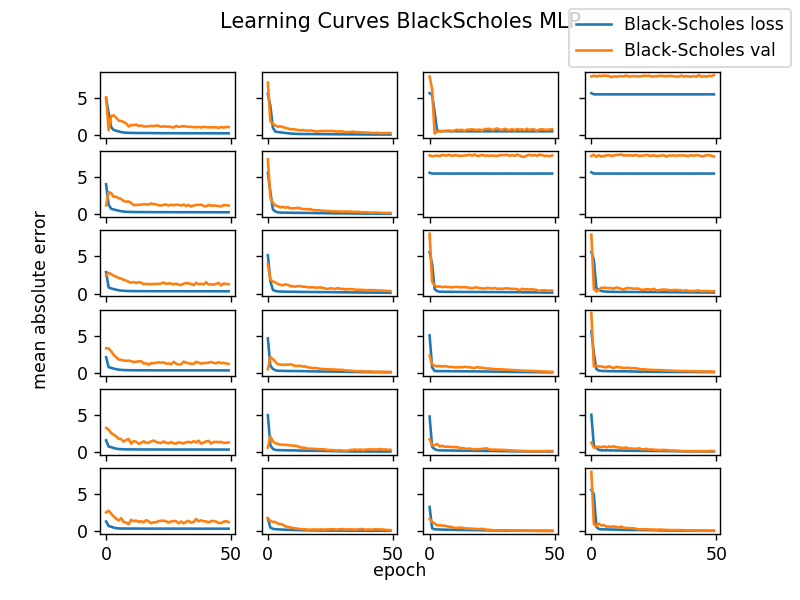

interactive(children=(RadioButtons(description='Pricing Model:', options=('BlackScholes', 'Heston'), value='Bl…

In [11]:
num_unit_ranges = len(range_units)
num_layer_ranges = len(range_layers)

fig, axes = plt.subplots(nrows=num_unit_ranges, ncols=num_layer_ranges, sharex=True, sharey=True)

@interact(pricing_model=wg.RadioButtons(options=pricing_models,
                                       value='BlackScholes',
                                       description='Pricing Model:'),
          network_type=wg.RadioButtons(options=['MLP', 'LSTM'],
                                       value='MLP',
                                       description='Network Type:'))
def plot_learning_curves(pricing_model, network_type):
    mgrid = model_grids[pricing_model][network_type]
    fig.suptitle('Learning Curves %s %s' % (pricing_model, network_type))
    for u in range(num_unit_ranges):
        for l in range(num_layer_ranges):
            axes[u][l].clear()
            axes[u][l].plot(mgrid.history[u][l]['mean_absolute_error'], label='Black-Scholes loss')
            axes[u][l].plot(mgrid.history[u][l]['val_mean_absolute_error'], label='Black-Scholes val')
            #axes[u][l].plot(history[range_units[u]][range_layers[l]].history['mean_absolute_error'], label='MAE')
            #axes[u][l].set_ylabel('Loss')
            #axes[u][l].set_xlabel('Epoch')
    
    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.text(0.5, 0.04, 'epoch', ha='center')
    fig.text(0.04, 0.5, 'mean absolute error', va='center', rotation='vertical')
    export_figure(fig, 'learning_curves_%s_%s' % (pricing_model, network_type))

In [33]:
model_grids[pricing_models[0]]

{'MLP': <keras_grid.model_grid.MLPGrid at 0x1bc4c1f0a90>,
 'LSTM': <keras_grid.model_grid.LSTMGrid at 0x1bc5c7eafd0>}

<IPython.core.display.Javascript object>


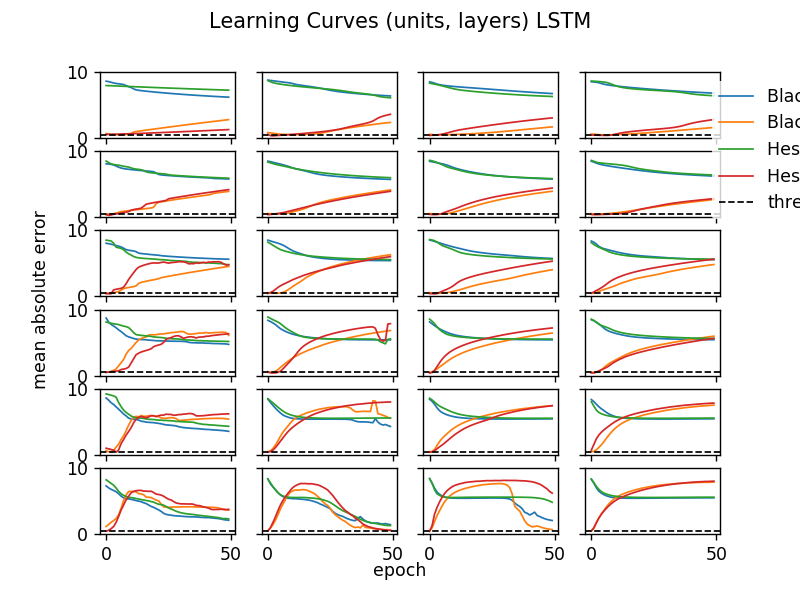

interactive(children=(RadioButtons(description='Network Type:', index=1, options=('MLP', 'LSTM'), value='LSTM'…

In [44]:
num_unit_ranges = len(range_units)
num_layer_ranges = len(range_layers)

fig, axes = plt.subplots(nrows=num_unit_ranges, ncols=num_layer_ranges, sharex=True, sharey=True)

@interact(network_type=wg.RadioButtons(options=['MLP', 'LSTM'],
                                       value='LSTM',
                                       description='Network Type:'))
def plot_learning_curves(network_type):
    fig.suptitle('Learning Curves (units, layers) %s' % network_type)
    lwidth=1
    for u in range(num_unit_ranges):
        for l in range(num_layer_ranges):
            axes[u][l].clear()
            axes[u][l].plot(model_grids[pricing_models[0]][network_type].history[u][l]['mean_absolute_error'], lw=lwidth, label='Black-Scholes bias')
            axes[u][l].plot(model_grids[pricing_models[0]][network_type].history[u][l]['val_mean_absolute_error'], lw=lwidth, label='Black-Scholes variance')
            axes[u][l].plot(model_grids[pricing_models[1]][network_type].history[u][l]['mean_absolute_error'], lw=lwidth, label='Heston bias')
            axes[u][l].plot(model_grids[pricing_models[1]][network_type].history[u][l]['val_mean_absolute_error'], lw=lwidth, label='Heston variance')       
            axes[u][l].set_ylim([0, 10])
            axes[u][l].axhline(0.5, color='k', linestyle='--', lw=lwidth, label='threshold')
    handles, labels = axes[0][0].get_legend_handles_labels()
    leg = fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.23, 0.88))
    leg.get_frame().set_linewidth(0.0)
    fig.text(0.5, 0.04, 'epoch', ha='center')
    fig.text(0.04, 0.5, 'mean absolute error', va='center', rotation='vertical')
    export_figure(fig, 'learning_curves_%s' %  network_type, bbox_inches='tight')

In this grid the rows represent the increasing number of units and the columns the increasing number of layers. If we apply the algorithm described [here](https://github.com/niknow/machine-learning-examples/blob/master/network_topology_selection/network_topology_selection.ipynb) to chose the final candidate, i.e. if we chose a threshold of $0.1$ for bias (blue) and variance (orange) of the network, then the first row and the second column already does the trick for the MLP. There is no substantial difference in that regard between Black-Scholes and Heston.
For the LSTM, none of the models of the grid manage to learn the objective with a bias and a variance below the $0.1$ threshold. If we relax this to $1$, we manage to be below that for the last row (i.e. the maximum number of units) and the second column for both Heston and Black-Scholes model. 
Thus, as expected, the additional complexities of the LSTM ironically prevent it from fitting the prices better than the MLP. That is excel at problems where complex dependencies of long-term and short-term memory play a role, but the paths are Markovian, i.e. have no memory here. Thus, the MLP manages to learn the pricing function better as no degrees of freedom are wasted to be able to deal with an obstacle, which is not present in this pricing problem.

In [22]:
np.array(list(range(2,6)))

array([2, 3, 4, 5])

## Selecting & Inspecting the Final Candidates
Based on the above reasoning, we chose the final candiates.

In [45]:
model = {'BlackScholes': {
            'MLP': model_grids['BlackScholes']['MLP'][2][1],
            'LSTM': model_grids['BlackScholes']['LSTM'][5][1]},
        'Heston': {
            'MLP': model_grids['Heston']['MLP'][2][1],
            'LSTM': model_grids['Heston']['LSTM'][5][1]},         
        }

## Statistics
We evaluate the chosen models in a few standard metrics.

In [46]:
model['BlackScholes']['MLP'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 29)                87        
_________________________________________________________________
dense_140 (Dense)            (None, 29)                870       
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 30        
Total params: 987
Trainable params: 987
Non-trainable params: 0
_________________________________________________________________


In [47]:
model['BlackScholes']['LSTM'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_112 (LSTM)              (None, 300, 25)           2700      
_________________________________________________________________
lstm_113 (LSTM)              (None, 300, 25)           5100      
_________________________________________________________________
dense_214 (Dense)            (None, 300, 1)            26        
Total params: 7,826
Trainable params: 7,826
Non-trainable params: 0
_________________________________________________________________


In [39]:
2*29+29 + 29*29+29 + 29*1+1

987

In [62]:
# traning samples per parameters
df.shape[0] / model['BlackScholes']['MLP'].count_params(), df.shape[0] / model['BlackScholes']['LSTM'].count_params()

(510.63829787234044, 14.740203906154035)

In [63]:
model['BlackScholes']['MLP'].evaluate(df[['K', 'T']], df['C_BlackScholes'])

120000/120000 [==============================] - 36s 300us/step


[0.05143695734929455, 0.05143695734929455, 0.11532843768497308]

In [64]:
model['BlackScholes']['LSTM'].evaluate(data_lstm['BlackScholes'][:, :, 0][:, :, np.newaxis], data_lstm['BlackScholes'][:, :, 1][:, :, np.newaxis])

400/400 [==============================] - 9s 23ms/step


[8.17933144569397, 8.179331865310669, 2.3420111417770384]

## Predictions
We compare the quality of predictions made by the trained model.

<IPython.core.display.Javascript object>


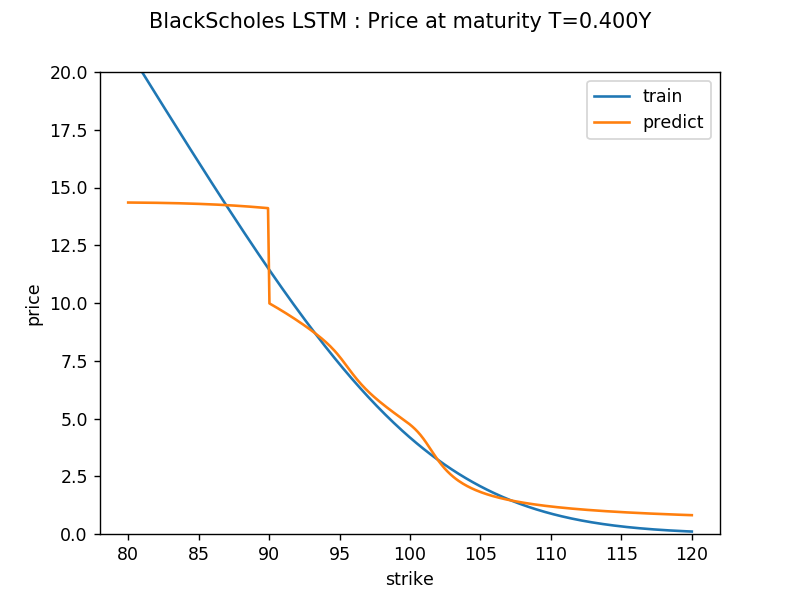

interactive(children=(RadioButtons(description='Pricing Model:', options=('BlackScholes', 'Heston'), value='Bl…

In [43]:
lstmx = {pricing_model: data_lstm[pricing_model][:, :, 0][:, :, np.newaxis] for pricing_model in pricing_models}
lstmy = {pricing_model: data_lstm[pricing_model][:, :, 1][:, :, np.newaxis] for pricing_model in pricing_models}
lstmpred = {pricing_model: model[pricing_model]['LSTM'].predict(lstmx[pricing_model]) for pricing_model in pricing_models}

fig, ax = plt.subplots()

@interact(pricing_model=wg.RadioButtons(options=pricing_models,
                                       value='BlackScholes',
                                       description='Pricing Model:'),
          network_type=wg.RadioButtons(options=['MLP', 'LSTM'],
                                       value='MLP',
                                       description='Network Type:'),
          matindex=wg.IntSlider(min=0, max=maturity_grid.shape[0]-1, value=0),)
def plot_slice(pricing_model, network_type, matindex):
    fig.suptitle(pricing_model + ' ' + network_type + ' ' + ': Price at maturity T={0:.3f}Y'.format(maturity_grid[matindex]))
    ax.clear()
    if network_type=='MLP':
        df_slice = df[df['T']==maturity_grid[matindex]]
        ax.plot(df_slice['K'], df_slice['C_'+pricing_model], label='train')
        ax.plot(df_slice['K'], model[pricing_model]['MLP'].predict(df_slice[['K', 'T']]), label='predict')
    else:
        ax.plot(lstmx[pricing_model][:, matindex, :], lstmy[pricing_model][:, matindex, :], label='train')
        ax.plot(lstmx[pricing_model][:, matindex, :], lstmpred[pricing_model][:, matindex, :], label='predict')
    ax.set_xlabel('strike')
    ax.set_ylabel('price')
    ax.legend()
    ax.set_ylim([0,20])
    export_figure(fig, 'predictions_%s_%s' % (pricing_model, network_type) )

In line with the learning curves, we find that the MLP fits the data better than the LSTM.

<IPython.core.display.Javascript object>


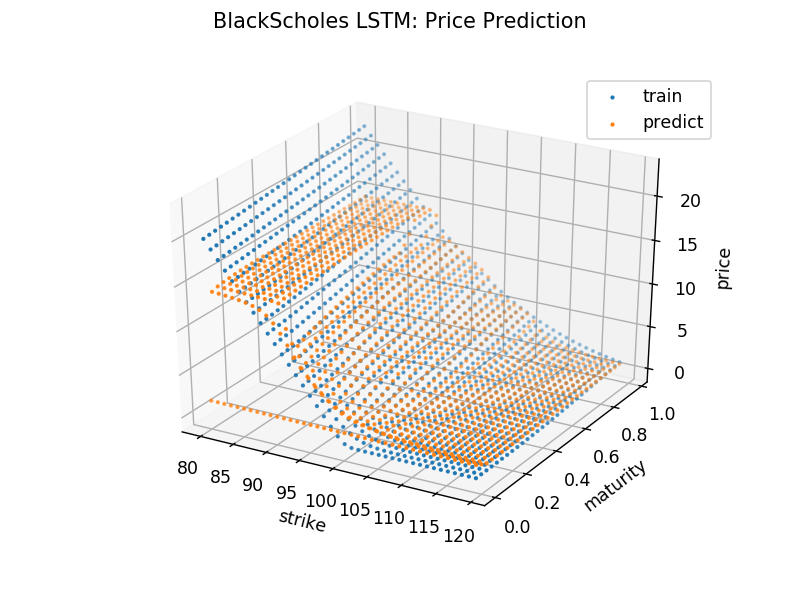

interactive(children=(RadioButtons(description='Pricing Model:', options=('BlackScholes', 'Heston'), value='Bl…

In [48]:
# 3D view of predictions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# thinning out the df to avoid performance issues in the plot
df_3dplot = df[(df['T'].isin(maturity_grid[::10])) & (df['K'].isin(strike_grid[::10]))]

@interact(pricing_model=wg.RadioButtons(options=pricing_models,
                                       value='BlackScholes',
                                       description='Pricing Model:'),
          network_type=wg.RadioButtons(options=['MLP', 'LSTM'],
                                       value='MLP',
                                       description='Network Type:'))
def plot_3d_predictions(pricing_model, network_type):
    fig.suptitle(pricing_model + ' ' + network_type + ': Price Prediction')
    ax.clear()
    if network_type=='MLP':
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], df_3dplot['C_'+pricing_model], s=2, label='train')
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], model[pricing_model]['MLP'].predict(df_3dplot[['K', 'T']]), s=2, label='predict')
    else:
        ax.scatter3D(lstmx[pricing_model][::10, ::10, :], df_3dplot['T'], lstmy[pricing_model][::10, ::10, :], s=2, label='train')
        ax.scatter3D(lstmx[pricing_model][::10, ::10, :], df_3dplot['T'], lstmpred[pricing_model][::10, ::10, :], s=2, label='predict')        
    ax.legend()
    ax.set_xlabel('strike')
    ax.set_ylabel('maturity')
    ax.set_zlabel('price')
    export_figure(fig, 'predictions_3d_%s_%s' % (pricing_model, network_type) )
    plt.show()

# Conclusion

* The overall champion model to learn the Black-Scholes (or Heston) pricing formula is the MLP with $n_L=3$ layers and $n_u=13$ units (equivalent to $64$ initial number of units). 
* The performance of the champion MLP on the Black-Scholes model and the Heston model is comparable.
* The LSTM is not a good network topology choice for learning the pricing formula of either of the two models.
* The performance of the networks is much worse on the boundary than it is in the interior of the data set. An easy way out of this is to choose the training set slightly bigger than needed in practice.